# Analyse temporelle & clustering des Client et produits dans le temps 

**Dataset : Online Retail II (2009-12-01 → 2011-12-09)**

Objectifs :
- Comprendre l'évolution des ventes dans le temps (tendance, saisonnalité, pics).

In [1]:
%pip install tslearn
%pip install -q sentence-transformers gensim
%pip install -q  gensim
%pip install  umap-learn hdbscan


     ---------------------------------------- 11.1/11.1 MB 4.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## 1. Import des librairies et chargement des données


In [2]:
# 1. Import des librairies de base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.cluster.hierarchy import dendrogram, linkage
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sentence_transformers import SentenceTransformer
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler, OneHotEncoder


pd.set_option('display.max_columns', None)

# 2. Chargement des données
xlsx_path = "online_retail_II.xlsx"  
sheets = pd.read_excel(xlsx_path, sheet_name=None)

raw = pd.concat(sheets.values(), ignore_index=True)

print('Feuilles chargées:', list(sheets.keys()))
print('Taille totale:', raw.shape)

raw.head()


Feuilles chargées: ['Year 2009-2010', 'Year 2010-2011']
Taille totale: (1067371, 8)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## 2. Compréhension du dataset
- **Invoice** : ID de la facture (peut commencer par 'C' si c'est un avoir/retour).
- **StockCode** : code produit.
- **Description** : nom du produit.
- **Quantity** : quantité commandée (peut être négative si retour).
- **InvoiceDate** : date + heure de la transaction.
- **Price** : prix unitaire.
- **Customer ID** : identifiant client.
- **Country** : pays du client.


In [3]:
raw.info()
raw.describe(include='all').T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
Invoice,1067371.0,53628.0,537434.0,1350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
StockCode,1067371,5305,85123A,5829,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Description,1062989,5698,WHITE HANGING HEART T-LIGHT HOLDER,5918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Quantity,1067371.0,NaN,NaN,NaN,9.938898,-80995.0,1.0,3.0,10.0,80995.0,172.705794
InvoiceDate,1067371,NaN,NaN,NaN,2011-01-02 21:13:55.394028544,2009-12-01 07:45:00,2010-07-09 09:46:00,2010-12-07 15:28:00,2011-07-22 10:23:00,2011-12-09 12:50:00,NaN
Price,1067371.0,NaN,NaN,NaN,4.649388,-53594.36,1.25,2.1,4.15,38970.0,123.553059
Customer ID,824364.0,NaN,NaN,NaN,15324.638504,12346.0,13975.0,15255.0,16797.0,18287.0,1697.46445
Country,1067371,43,United Kingdom,981330,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Nettoyage et préparation
Objectif : préparer des données fiables pour l'analyse temporelle et le clustering.

- On enlève les lignes où la quantité ou le prix sont <= 0. 
- On enlève les lignes sans `Customer ID` pour les analyses client.
- On crée `TotalPrice = Quantity * Price`.
- On convertit les dates et on crée des colonnes temporelles (année, mois, jour...).


In [4]:
data = raw.copy()

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['TotalPrice'] = data['Quantity'] * data['Price']

rows_before = data.shape[0]

#. Garder seulement les vraies ventes positives
sales = data[(data['Quantity'] > 0) & (data['Price'] > 0)].copy()

# Enlever les clients anonymes
sales = sales.dropna(subset=['Customer ID']).copy()

sales['Customer ID'] = sales['Customer ID'].astype(str)

# 7. Créer des colonnes temporelles utiles
sales['InvoiceYear'] = sales['InvoiceDate'].dt.year
sales['InvoiceMonth'] = sales['InvoiceDate'].dt.to_period('M')     # ex: 2011-03
sales['InvoiceDay'] = sales['InvoiceDate'].dt.to_period('D')       # ex: 2011-03-15
sales['InvoiceDate_date'] = sales['InvoiceDate'].dt.date           # version date pure

rows_after = sales.shape[0]

print("Taille AVANT nettoyage :", rows_before)
print("Taille APRÈS nettoyage :", rows_after)
print("On a retiré :", rows_before - rows_after, "lignes")

print("\nAperçu après nettoyage :")
display(sales.head())

print("\nValeurs manquantes (après nettoyage) :")
missing_after = sales.isna().mean().sort_values(ascending=False) * 100
print(missing_after)

print("\nStats basiques sur les montants :")
display(sales[['Quantity', 'Price', 'TotalPrice']].describe())


Taille AVANT nettoyage : 1067371
Taille APRÈS nettoyage : 805549
On a retiré : 261822 lignes

Aperçu après nettoyage :


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,InvoiceYear,InvoiceMonth,InvoiceDay,InvoiceDate_date
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,2009-12,2009-12-01,2009-12-01
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,2009-12,2009-12-01,2009-12-01
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,2009-12,2009-12-01,2009-12-01
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,2009-12,2009-12-01,2009-12-01
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,2009-12,2009-12-01,2009-12-01



Valeurs manquantes (après nettoyage) :
Invoice             0.0
StockCode           0.0
Description         0.0
Quantity            0.0
InvoiceDate         0.0
Price               0.0
Customer ID         0.0
Country             0.0
TotalPrice          0.0
InvoiceYear         0.0
InvoiceMonth        0.0
InvoiceDay          0.0
InvoiceDate_date    0.0
dtype: float64

Stats basiques sur les montants :


,Quantity,Price,TotalPrice
count,805549.000000,805549.000000,805549.000000
mean,13.290522,3.206561,22.026505
std,143.634088,29.199173,224.041928
min,1.000000,0.001000,0.001000
25%,2.000000,1.250000,4.950000
50%,5.000000,1.950000,11.850000
75%,12.000000,3.750000,19.500000
max,80995.000000,10953.500000,168469.600000


In [5]:
sales['Customer ID'] = sales['Customer ID'].astype(str)

## 4. Agrégation temporelle (séries mensuelles / journalières)

On calcule par mois :
- Revenu total (`revenue` = somme TotalPrice)
- Quantité vendue totale
- Nombre de factures uniques
- Nombre de clients uniques
- Panier moyen (revenu / nb factures)


Aperçu de la table mensuelle :


,revenue,quantity,nb_invoices,nb_customers,avg_basket
InvoiceMonth,,,,,
2009-12,686654.160,400153,1512,955,454.136349
2010-01,557319.062,370921,1011,720,551.255254



Statistiques globales sur le revenu mensuel :


count    2.500000e+01
mean     7.097372e+05
std      2.116144e+05
min      4.471373e+05
25%      5.916367e+05
50%      6.390666e+05
75%      8.316150e+05
max      1.172336e+06
Name: revenue, dtype: float64

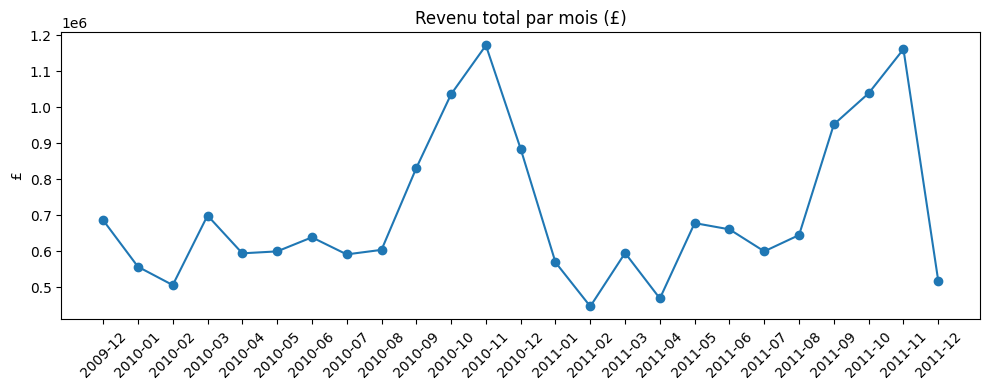

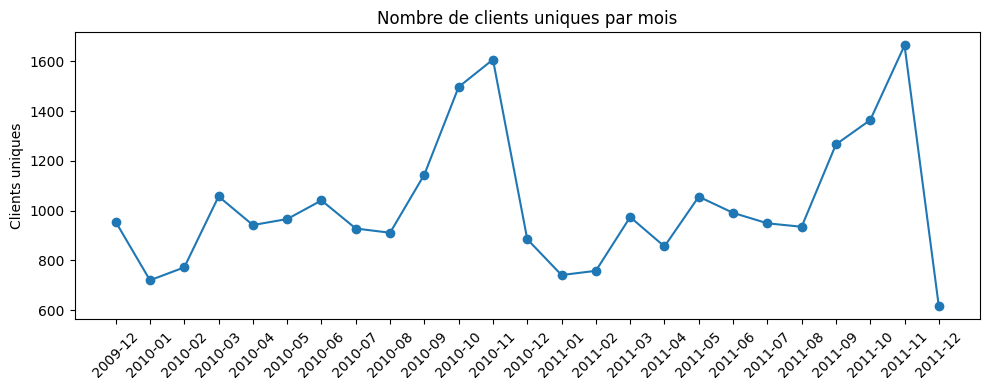

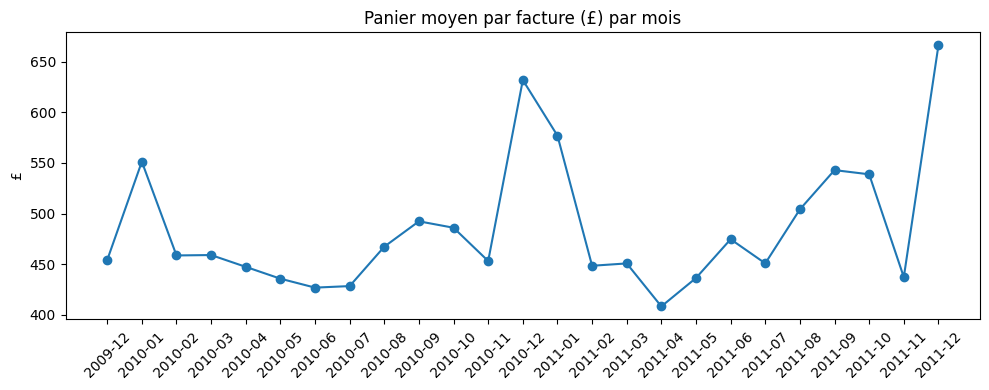

In [6]:
# Agrégation mensuelle
monthly = (
    sales
    .groupby('InvoiceMonth')
    .agg(
        revenue=('TotalPrice', 'sum'),
        quantity=('Quantity', 'sum'),
        nb_invoices=('Invoice', pd.Series.nunique),
        nb_customers=('Customer ID', pd.Series.nunique)
    )
    .sort_index()
)

monthly['avg_basket'] = monthly['revenue'] / monthly['nb_invoices']

print("Aperçu de la table mensuelle :")
display(monthly.head(2))

print("\nStatistiques globales sur le revenu mensuel :")
display(monthly['revenue'].describe())

monthly_ts = monthly.copy()
monthly_ts.index = monthly_ts.index.to_timestamp()

# Visualisation : revenu mensuel
plt.figure(figsize=(10,4))
plt.plot(monthly.index.astype(str), monthly['revenue'], marker='o')
plt.xticks(rotation=45)
plt.title("Revenu total par mois (£)")
plt.ylabel("£")
plt.tight_layout()
plt.show()

# Visualisation : nombre de clients uniques
plt.figure(figsize=(10,4))
plt.plot(monthly.index.astype(str), monthly['nb_customers'], marker='o')
plt.xticks(rotation=45)
plt.title("Nombre de clients uniques par mois")
plt.ylabel("Clients uniques")
plt.tight_layout()
plt.show()

# Visualisation : panier moyen
plt.figure(figsize=(10,4))
plt.plot(monthly.index.astype(str), monthly['avg_basket'], marker='o')
plt.xticks(rotation=45)
plt.title("Panier moyen par facture (£) par mois")
plt.ylabel("£")
plt.tight_layout()
plt.show()


## 4. Décomposition temporelle : tendance vs saisonnalité

Objectif :
- Séparer le revenu mensuel en trois composantes :
  - tendance long terme (trend)
  - saisonnalité récurrente (seasonal)
  - bruit / événements spécifiques (resid)
  
On teste deux hypothèses :
- Modèle **additif** : saisonnalité d'amplitude constante.
- Modèle **multiplicatif** : saisonnalité proportionnelle au niveau global des ventes.


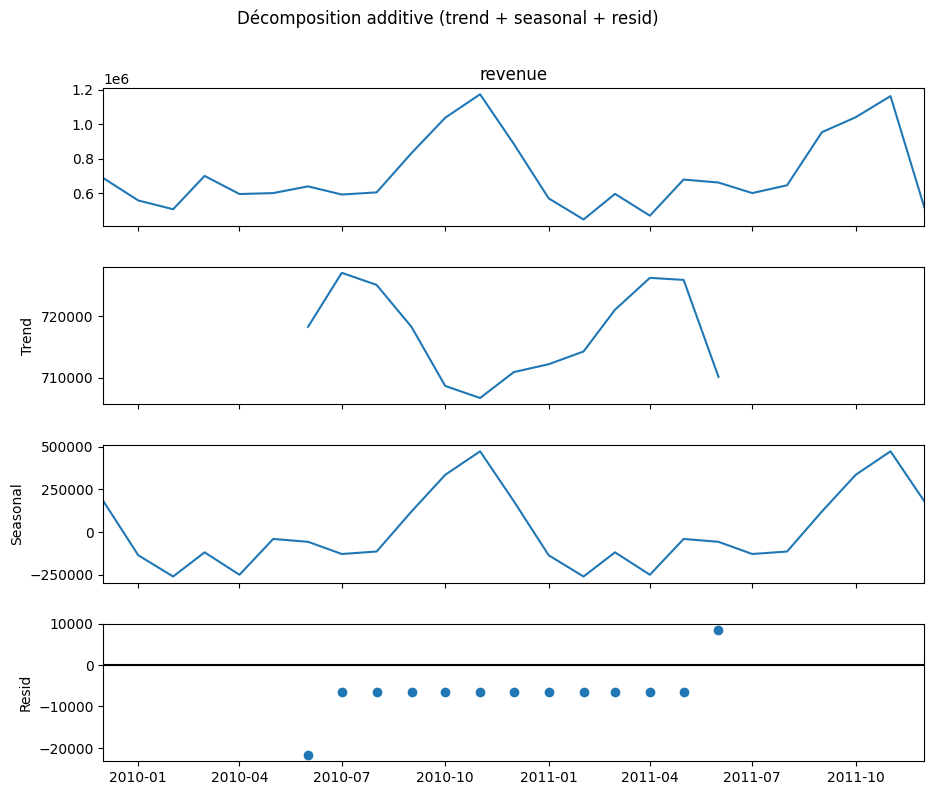

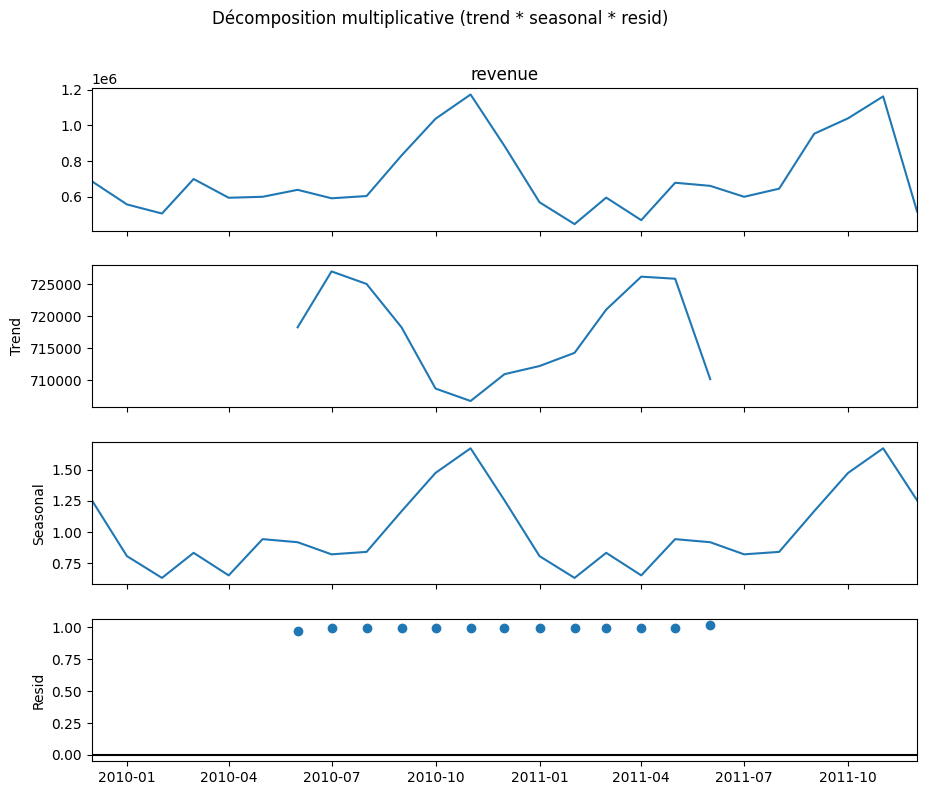

In [7]:
# On prend la série du revenu mensuel avec index datetime
series_rev = monthly_ts['revenue']

# Décomposition additive
decomp_add = seasonal_decompose(series_rev, model='additive', period=12)

# Décomposition multiplicative
decomp_mult = seasonal_decompose(series_rev, model='multiplicative', period=12)

# Plot additif
fig_add = decomp_add.plot()
fig_add.set_size_inches(10,8)
plt.suptitle("Décomposition additive (trend + seasonal + resid)", y=1.02)
plt.show()

# Plot multiplicatif
fig_mult = decomp_mult.plot()
fig_mult.set_size_inches(10,8)
plt.suptitle("Décomposition multiplicative (trend * seasonal * resid)", y=1.02)
plt.show()


## 5. Préparation du clustering client (profil temporel)

Objectif :
Nous voulons regrouper les clients selon **leur comportement dans le temps**.


In [8]:
# 1. Revenu par client et par mois
client_month = (
    sales
    .groupby(['Customer ID', 'InvoiceMonth'])
    .agg(revenue=('TotalPrice', 'sum'))
    .reset_index()
)

print("Aperçu du revenu client/mois :")
display(client_month.head())

# 2. Pivot -> lignes = clients, colonnes = mois, valeurs = revenu
client_month_pivot = client_month.pivot_table(
    index='Customer ID',
    columns='InvoiceMonth',
    values='revenue',
    fill_value=0  # si le client n'a rien acheté ce mois-là
)

print("Taille matrice client x mois :", client_month_pivot.shape)
display(client_month_pivot.head())

# On va aussi regarder la distribution du total dépensé par client (somme sur tous les mois)
client_total_spend = client_month_pivot.sum(axis=1)
print("\nStats sur le total dépensé par client sur toute la période :")
display(client_total_spend.describe())


Aperçu du revenu client/mois :


,Customer ID,InvoiceMonth,revenue
0,12346.0,2009-12,113.50
1,12346.0,2010-01,90.00
2,12346.0,2010-03,27.05
3,12346.0,2010-06,142.31
4,12346.0,2011-01,77183.60


Taille matrice client x mois : (5878, 25)


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
Customer ID,,,,,,,,,,,,,,,,,,,,,,,,,
12346.0,113.5,90.0,0.0,27.05,0.00,0.0,142.31,0.0,0.0,0.00,0.00,0.0,0.00,77183.60,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00
12347.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,611.53,0.0,1423.58,475.39,0.0,0.0,636.25,0.0,382.52,0.0,584.91,0.0,1294.32,0.00,224.82
12348.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,222.16,0.00,0.0,892.80,227.44,0.0,0.0,367.00,0.0,0.00,0.0,0.00,310.0,0.00,0.00,0.00
12349.0,0.0,0.0,0.0,0.00,1068.52,200.0,0.00,0.0,0.0,0.00,1402.62,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,1757.55,0.00
12350.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.00,334.4,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00



Stats sur le total dépensé par client sur toute la période :


count      5878.000000
mean       3018.616737
std       14737.731040
min           2.950000
25%         348.762500
50%         898.915000
75%        2307.090000
max      608821.650000
dtype: float64

### Normalisation avant clustering

In [9]:
# On garde une copie brute avant scaling (utile pour interpréter après)
client_month_pivot_raw = client_month_pivot.copy()

# Standardisation (moyenne = 0, écart-type = 1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(client_month_pivot)

print("Shape de X_scaled :", X_scaled.shape)
print("Exemple, 5 premières lignes de X_scaled :")
print(X_scaled[:5])


Shape de X_scaled : (5878, 25)
Exemple, 5 premières lignes de X_scaled :
[[-4.17721574e-03 -4.68622651e-03 -1.45068979e-01 -1.19894811e-01
  -1.89428131e-01 -1.84686678e-01  5.28674181e-02 -1.19982255e-01
  -1.27385020e-01 -1.44617730e-01 -2.04794495e-01 -2.12628076e-01
  -1.43267508e-01  6.44487165e+01 -1.54217753e-01 -1.73215767e-01
  -1.81217210e-01 -1.71082667e-01 -1.13125563e-01 -1.58992154e-01
  -1.29622646e-01 -1.19485216e-01 -1.52111390e-01 -2.10054976e-01
  -3.94821676e-02]
 [-1.47083690e-01 -9.22901035e-02 -1.45068979e-01 -1.55157375e-01
  -1.89428131e-01 -1.84686678e-01 -1.71126608e-01 -1.19982255e-01
  -1.27385020e-01 -1.44617730e-01  5.05307786e-01 -2.12628076e-01
   1.21197250e+00  3.16457282e-01 -1.54217753e-01 -1.73215767e-01
   1.26321937e+00 -1.71082667e-01  2.71557129e-01 -1.58992154e-01
   5.60948300e-01 -1.19485216e-01  9.61373171e-01 -2.10054976e-01
   6.12015080e-02]
 [-1.47083690e-01 -9.22901035e-02 -1.45068979e-01 -1.55157375e-01
  -1.89428131e-01 -1.84686678e-

k=2 → inertie=98874, silhouette=0.975
k=3 → inertie=82194, silhouette=0.956
k=4 → inertie=73738, silhouette=0.956
k=5 → inertie=67223, silhouette=0.833
k=6 → inertie=61907, silhouette=0.932
k=7 → inertie=55538, silhouette=0.815
k=8 → inertie=51403, silhouette=0.813
k=9 → inertie=48902, silhouette=0.822


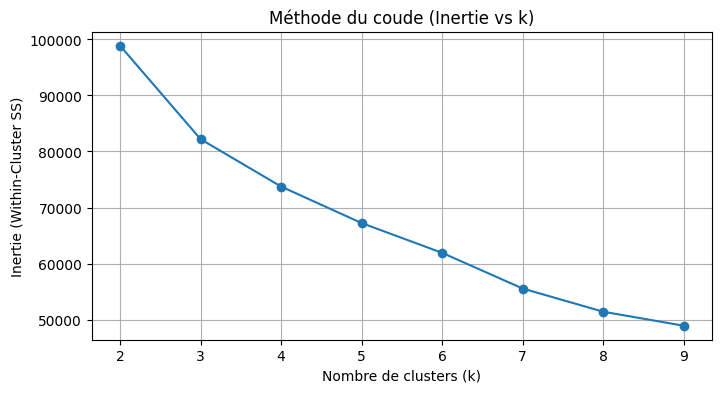

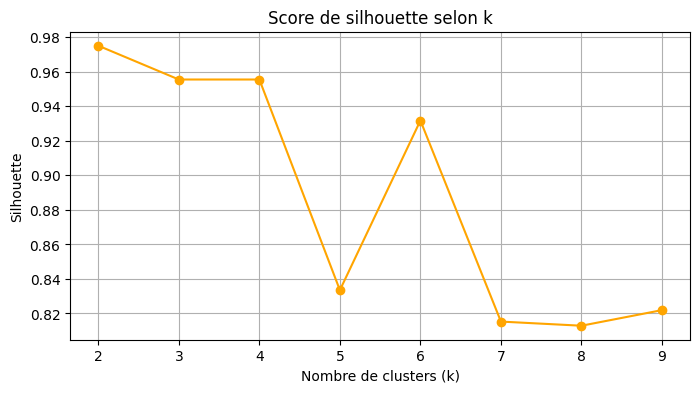

In [10]:
inertias = []
silhouettes = []
K_values = range(2, 10)  # on teste de 2 à 9 clusters

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouettes.append(sil_score)
    print(f"k={k} → inertie={kmeans.inertia_:.0f}, silhouette={sil_score:.3f}")

# Tracé du "coude" de l'inertie
plt.figure(figsize=(8,4))
plt.plot(K_values, inertias, marker='o')
plt.title("Méthode du coude (Inertie vs k)")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Inertie (Within-Cluster SS)")
plt.grid(True)
plt.show()

# Tracé du score de silhouette
plt.figure(figsize=(8,4))
plt.plot(K_values, silhouettes, marker='o', color='orange')
plt.title("Score de silhouette selon k")
plt.xlabel("Nombre de clusters (k)")
plt.ylabel("Silhouette")
plt.grid(True)
plt.show()


## 7. Clustering  des clients (k=4) 




In [11]:
best_k = 4  # choix basé sur analyse silhouette / inertie 

kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

# On ajoute l'étiquette de cluster à chaque client
client_clusters = pd.DataFrame({
    'Customer ID': client_month_pivot.index,
    'cluster': cluster_labels
})

display(client_clusters.head())

# Vérifions la taille de chaque cluster (combien de clients par cluster)
cluster_sizes = client_clusters['cluster'].value_counts().sort_index()
print("Taille de chaque cluster :")
print(cluster_sizes)


,Customer ID,cluster
0,12346.0,0
1,12347.0,0
2,12348.0,0
3,12349.0,0
4,12350.0,0


Taille de chaque cluster :
cluster
0    5861
1       1
2      15
3       1
Name: count, dtype: int64


### Visualisation des clusters dans l’espace réduit (PCA)

Pour mieux comprendre la structure des groupes obtenus avec KMeans (k=4),
nous projetons les clients dans un plan 2D à l’aide d’une analyse en composantes principales (PCA).



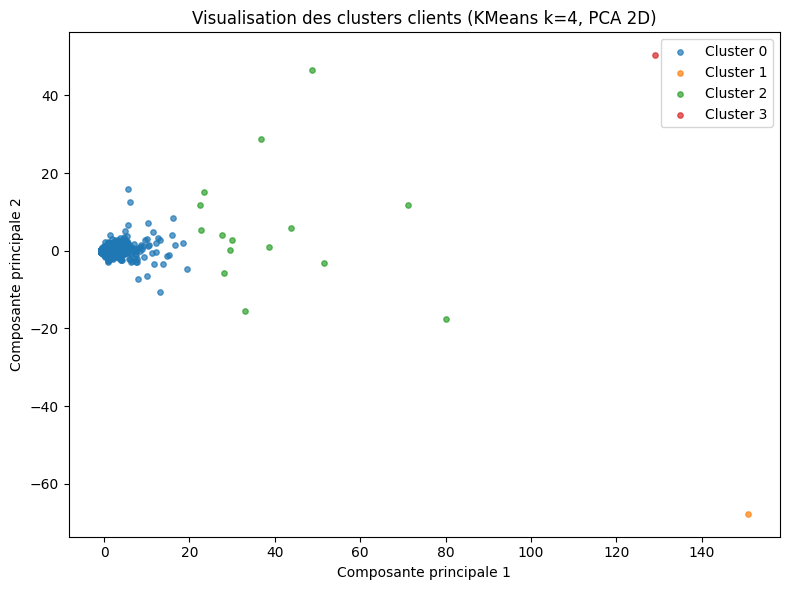

In [12]:
# Réduction à 2 dimensions pour visualiser
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Création d'un DataFrame pour la visualisation
df_visu = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_visu['cluster'] = cluster_labels

plt.figure(figsize=(8,6))
for c in sorted(df_visu['cluster'].unique()):
    subset = df_visu[df_visu['cluster'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=15, alpha=0.7, label=f"Cluster {c}")

plt.title("Visualisation des clusters clients (KMeans k=4, PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.tight_layout()
plt.show()


### Analyse du profil temporel moyen par cluster

Pour chaque cluster, on veut regarder *comment évolue la dépense moyenne par mois*.

### 7.1 Normalisation des features



InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cluster,,,,,,,,,,,,,,,,,,,,,,,,,
0,91.70316,62.732201,68.843065,96.193343,86.076793,84.624562,90.213624,79.610067,79.912001,112.063604,146.498476,169.481707,122.251843,78.879497,59.344414,78.528676,71.676868,90.612454,83.547529,81.101005,80.451124,120.822718,139.638789,170.720706,77.439614
1,41005.74000,38555.300000,24019.400000,21215.110000,16596.550000,13174.250000,15349.620000,52609.310000,46516.390000,0.000000,30195.560000,22092.510000,55669.220000,0.000000,10535.480000,6909.320000,1196.960000,18165.740000,41959.440000,22949.760000,985.920000,49622.180000,52681.270000,15331.080000,11485.540000
2,6231.98200,8146.200667,4124.904667,6073.984000,4670.536667,4854.998667,4757.126000,4579.011333,4405.929333,8814.215333,8761.906000,8247.794000,6920.849333,5377.042000,4399.120000,7124.831333,2995.248000,6729.406000,6952.879333,6785.482667,8833.742000,11221.570000,8547.908667,8034.455333,2741.576667
3,14696.47000,28897.320000,16988.890000,23494.940000,3458.510000,18002.000000,23618.020000,3747.660000,23273.080000,42596.990000,16428.280000,33194.340000,8591.880000,26476.680000,22797.460000,21462.400000,2976.560000,28408.140000,25288.990000,26.020000,40327.810000,26750.700000,39995.950000,25375.410000,11728.020000


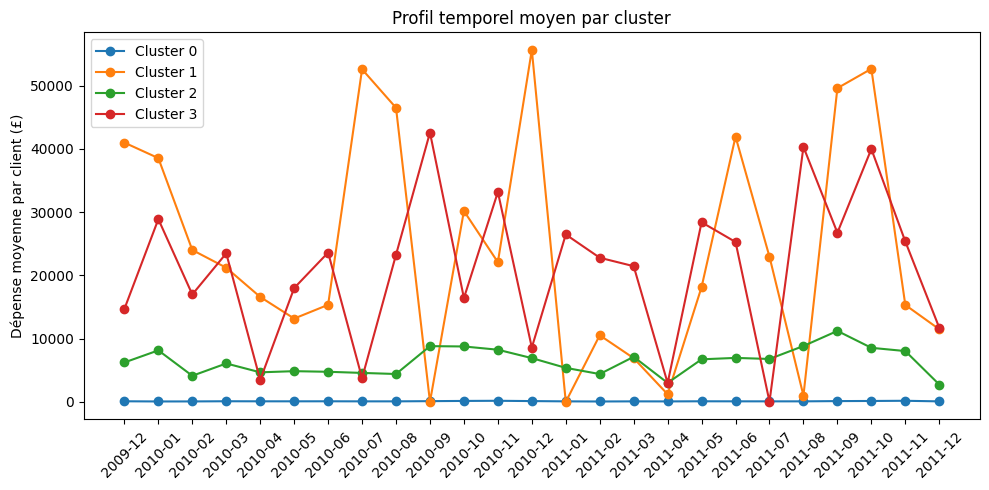

In [13]:
# On rattache les clusters aux timelines client x mois (dépenses mensuelles)
client_month_with_cluster = client_month_pivot_raw.copy()
client_month_with_cluster['cluster'] = cluster_labels

# Calculer la dépense moyenne par mois pour chaque cluster
cluster_time_profile = (
    client_month_with_cluster
    .groupby('cluster')
    .mean()  # moyenne par cluster, colonne = mois
)

display(cluster_time_profile.head())

# Visualiser l'évolution de chaque cluster dans le temps
plt.figure(figsize=(10,5))

for c in cluster_time_profile.index:
    plt.plot(
        cluster_time_profile.columns.astype(str),
        cluster_time_profile.loc[c],
        marker='o',
        label=f"Cluster {c}"
    )

plt.xticks(rotation=45)
plt.ylabel("Dépense moyenne par client (£)")
plt.title("Profil temporel moyen par cluster")
plt.legend()
plt.tight_layout()
plt.show()


### Contribution des clusters au chiffre d'affaire mensuel

on regarde l'impact  du comportement des clients 
sur business .


,InvoiceMonth,cluster,revenue,total_rev,share
0,2009-12,0,537472.220,686654.160,0.782741
1,2009-12,1,41005.740,686654.160,0.059718
2,2009-12,2,93479.730,686654.160,0.136138
3,2009-12,3,14696.470,686654.160,0.021403
4,2010-01,0,367673.432,557319.062,0.659718


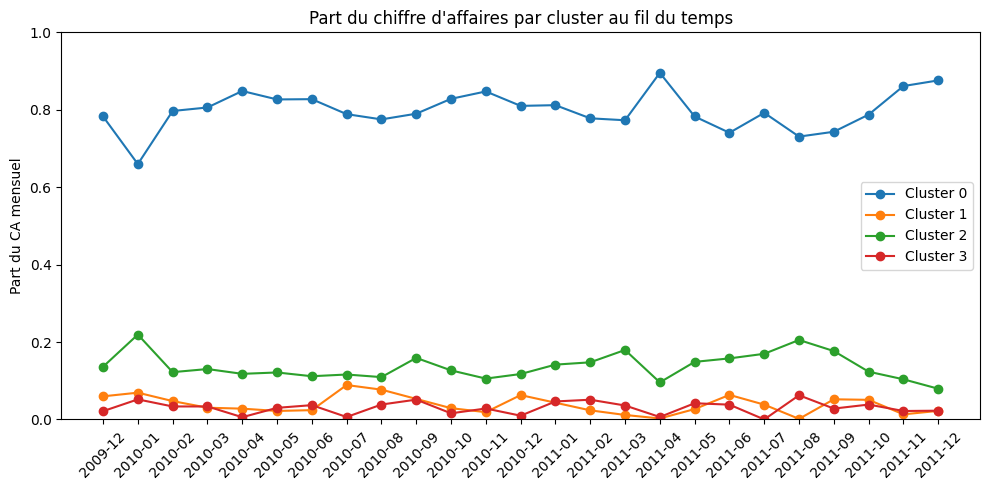

In [14]:
# On repart de la table client_month (Customer ID, InvoiceMonth, revenue)
# et on ajoute le cluster de chaque client
client_month_with_cluster_long = client_month.merge(
    client_clusters,
    on='Customer ID',
    how='left'
)

# CA total par mois et par cluster
cluster_evol = (
    client_month_with_cluster_long
    .groupby(['InvoiceMonth', 'cluster'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

# CA total par mois (tous clusters confondus)
total_month_rev = (
    client_month_with_cluster_long
    .groupby('InvoiceMonth')
    .agg(total_rev=('revenue', 'sum'))
    .reset_index()
)

# Merge pour calculer la part
cluster_evol = cluster_evol.merge(total_month_rev, on='InvoiceMonth')
cluster_evol['share'] = cluster_evol['revenue'] / cluster_evol['total_rev']

display(cluster_evol.head())

# Visualisation : part du CA par cluster dans le temps
plt.figure(figsize=(10,5))
for c in sorted(cluster_evol['cluster'].unique()):
    tmp = cluster_evol[cluster_evol['cluster'] == c]
    plt.plot(
        tmp['InvoiceMonth'].astype(str),
        tmp['share'],
        marker='o',
        label=f"Cluster {c}"
    )

plt.ylim(0,1)
plt.xticks(rotation=45)
plt.ylabel("Part du CA mensuel")
plt.title("Part du chiffre d'affaires par cluster au fil du temps")
plt.legend()
plt.tight_layout()
plt.show()


###  Clustering après transformation log (k=2):

On atténue l’effet des ultra-gros clients en appliquant log(1 + dépense).

On refait toute la pipeline KMeans dessus.

On regarde si maintenant les clusters sont plus équilibrés  plus interprétables pour du marketing.


In [15]:

# 1. Transformation log(1+x) pour écraser les gros montants
client_month_log = np.log1p(client_month_pivot_raw)  # log(1 + revenue)

# 2. Re-normalisation
scaler_log = StandardScaler()
X_scaled_log = scaler_log.fit_transform(client_month_log)

print("Shape après log:", X_scaled_log.shape)

# 3. On re-teste plusieurs k pour voir si l'équilibre des clusters s'améliore
inertias_log = []
silhouettes_log = []
K_values = range(2, 10)

for k in K_values:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled_log)
    inertias_log.append(km.inertia_)
    sil = silhouette_score(X_scaled_log, labels)
    silhouettes_log.append(sil)
    print(f"[LOG] k={k} -> inertie={km.inertia_:.0f}, silhouette={sil:.3f}")


Shape après log: (5878, 25)
[LOG] k=2 -> inertie=120152, silhouette=0.397
[LOG] k=3 -> inertie=113243, silhouette=0.274
[LOG] k=4 -> inertie=109269, silhouette=0.198
[LOG] k=5 -> inertie=106325, silhouette=0.087
[LOG] k=6 -> inertie=104045, silhouette=0.065
[LOG] k=7 -> inertie=101895, silhouette=0.070
[LOG] k=8 -> inertie=99730, silhouette=0.063
[LOG] k=9 -> inertie=98358, silhouette=0.066


In [16]:
best_k_log = 2

kmeans_log = KMeans(n_clusters=best_k_log, random_state=42, n_init=10)
labels_log = kmeans_log.fit_predict(X_scaled_log)

client_clusters_log = pd.DataFrame({
    'Customer ID': client_month_pivot_raw.index,
    'cluster_log': labels_log
})

print("Taille de chaque cluster (après log):")
print(client_clusters_log['cluster_log'].value_counts())


Taille de chaque cluster (après log):
cluster_log
1    5062
0     816
Name: count, dtype: int64


Shape de X_scaled_log : (5878, 25)


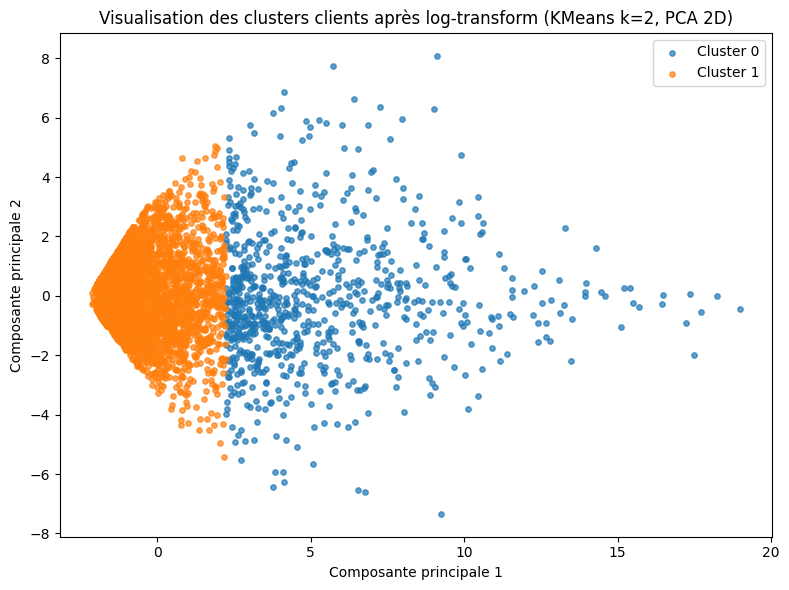

In [17]:
# 1️⃣ Appliquer la transformation logarithmique sur les montants
client_month_log = np.log1p(client_month_pivot_raw)  # log(1 + x)

# 2️⃣ Normalisation (centrage-réduction)
scaler_log = StandardScaler()
X_scaled_log = scaler_log.fit_transform(client_month_log)

print("Shape de X_scaled_log :", X_scaled_log.shape)

# Réduction à 2 dimensions avec PCA pour visualisation
pca_log = PCA(n_components=2, random_state=42)
X_pca_log = pca_log.fit_transform(X_scaled_log)

# Création d’un DataFrame pour la visualisation
df_visu_log = pd.DataFrame(X_pca_log, columns=['PC1', 'PC2'])
df_visu_log['cluster_log'] = labels_log

# Visualisation
plt.figure(figsize=(8,6))
for c in sorted(df_visu_log['cluster_log'].unique()):
    subset = df_visu_log[df_visu_log['cluster_log'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=15, alpha=0.7, label=f"Cluster {c}")

plt.title("Visualisation des clusters clients après log-transform (KMeans k=2, PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.tight_layout()
plt.show()


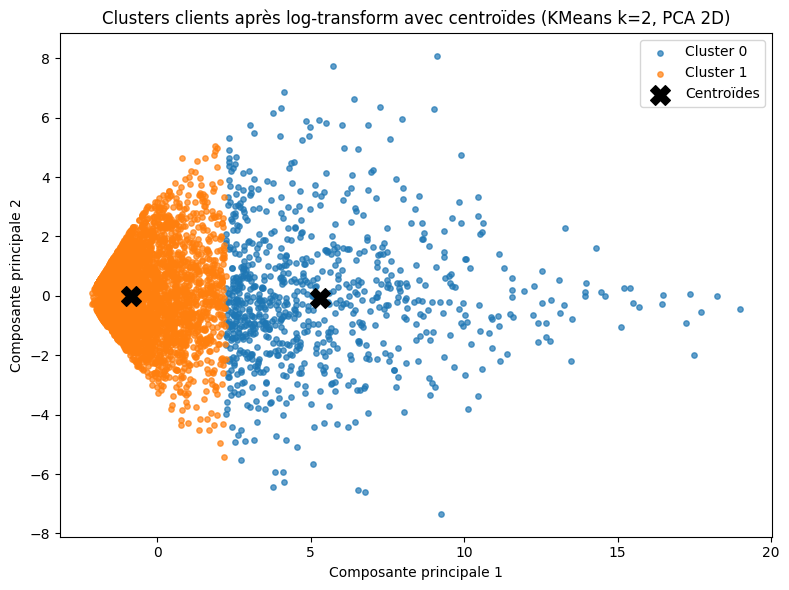

In [18]:
# Projection des centroïdes KMeans sur le plan PCA
centroids_pca_log = pca_log.transform(kmeans_log.cluster_centers_)

plt.figure(figsize=(8,6))
for c in sorted(df_visu_log['cluster_log'].unique()):
    subset = df_visu_log[df_visu_log['cluster_log'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=15, alpha=0.7, label=f"Cluster {c}")

# Ajout des centroïdes
plt.scatter(centroids_pca_log[:, 0], centroids_pca_log[:, 1],
            s=200, c='black', marker='X', label='Centroïdes')

plt.title("Clusters clients après log-transform avec centroïdes (KMeans k=2, PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.tight_layout()
plt.show()


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cluster_log,,,,,,,,,,,,,,,,,,,,,,,,,
0,582.977757,492.455295,392.042760,546.587243,455.979007,480.677292,527.823799,497.216127,514.778542,652.650699,740.229436,905.966963,813.412328,428.455956,391.214375,498.674951,340.886839,568.523015,524.049473,492.514154,557.783235,719.71299,734.737451,784.624473,262.097696
1,41.672128,30.714251,36.836068,50.097551,43.960949,41.041707,41.162062,36.726270,36.385492,59.077841,85.470719,85.552548,43.628493,43.426507,25.267961,37.254445,37.739372,42.410071,46.145658,39.154378,37.572655,72.21505,86.877327,103.035126,60.122298


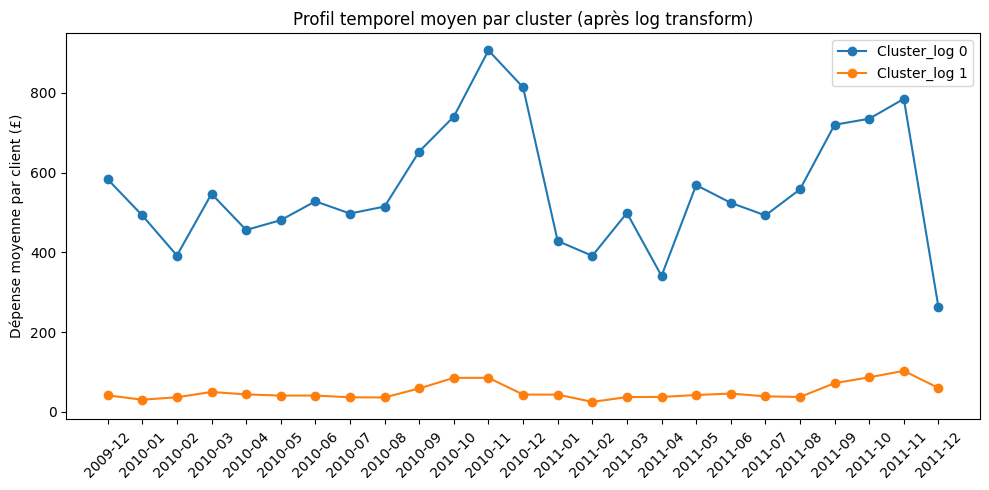

In [19]:
# Profil temporel moyen des clusters (version log)
# rattacher les clusters log aux dépenses réelles par mois
client_month_with_cluster_log = client_month_pivot_raw.copy()
client_month_with_cluster_log['cluster_log'] = labels_log

# moyenne par cluster et par mois
cluster_time_profile_log = (
    client_month_with_cluster_log
    .groupby('cluster_log')
    .mean()  
)

display(cluster_time_profile_log)

plt.figure(figsize=(10,5))
for c in cluster_time_profile_log.index:
    plt.plot(
        cluster_time_profile_log.columns.astype(str),
        cluster_time_profile_log.loc[c],
        marker='o',
        label=f"Cluster_log {c}"
    )

plt.xticks(rotation=45)
plt.ylabel("Dépense moyenne par client (£)")
plt.title("Profil temporel moyen par cluster (après log transform)")
plt.legend()
plt.tight_layout()
plt.show()


,InvoiceMonth,cluster_log,revenue,total_rev,share
0,2009-12,0,475709.850,686654.160,0.692794
1,2009-12,1,210944.310,686654.160,0.307206
2,2010-01,0,401843.521,557319.062,0.721030
3,2010-01,1,155475.541,557319.062,0.278970
4,2010-02,0,319906.892,506371.066,0.631764


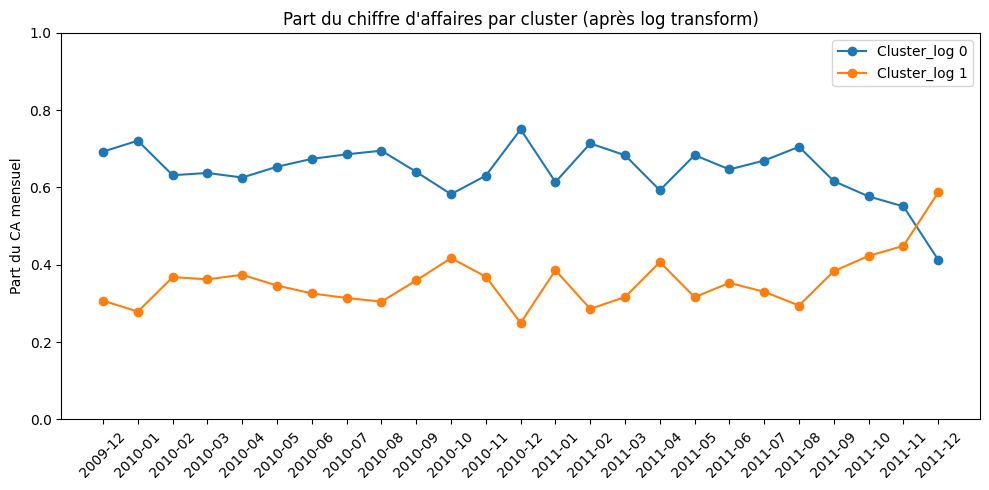

In [20]:

client_month_with_cluster_long_log = client_month.merge(
    client_clusters_log.rename(columns={'cluster_log': 'cluster_log'}),
    on='Customer ID',
    how='left'
)

cluster_evol_log = (
    client_month_with_cluster_long_log
    .groupby(['InvoiceMonth', 'cluster_log'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

total_month_rev_log = (
    client_month_with_cluster_long_log
    .groupby('InvoiceMonth')
    .agg(total_rev=('revenue', 'sum'))
    .reset_index()
)

cluster_evol_log = cluster_evol_log.merge(total_month_rev_log, on='InvoiceMonth')
cluster_evol_log['share'] = cluster_evol_log['revenue'] / cluster_evol_log['total_rev']

display(cluster_evol_log.head())

plt.figure(figsize=(10,5))
for c in sorted(cluster_evol_log['cluster_log'].unique()):
    tmp = cluster_evol_log[cluster_evol_log['cluster_log'] == c]
    plt.plot(
        tmp['InvoiceMonth'].astype(str),
        tmp['share'],
        marker='o',
        label=f"Cluster_log {c}"
    )

plt.ylim(0,1)
plt.xticks(rotation=45)
plt.ylabel("Part du CA mensuel")
plt.title("Part du chiffre d'affaires par cluster (après log transform)")
plt.legend()
plt.tight_layout()
plt.show()


In [21]:

sil_scores_agg = []
cluster_sizes_agg = {}

for k in [2, 3, 4]:
    agg = AgglomerativeClustering(n_clusters=k, linkage='ward')
    labels_agg = agg.fit_predict(X_scaled_log)

    sil = silhouette_score(X_scaled_log, labels_agg)
    sil_scores_agg.append((k, sil))
    
    sizes = pd.Series(labels_agg).value_counts().sort_index()
    cluster_sizes_agg[k] = sizes
    
    print(f"Agglomerative k={k} → silhouette={sil:.3f}")
    print("Tailles des clusters :")
    print(sizes)
    print("-" * 40)

sil_scores_agg


Agglomerative k=2 → silhouette=0.344
Tailles des clusters :
0    1042
1    4836
Name: count, dtype: int64
----------------------------------------
Agglomerative k=3 → silhouette=0.302
Tailles des clusters :
0    4836
1     814
2     228
Name: count, dtype: int64
----------------------------------------
Agglomerative k=4 → silhouette=0.028
Tailles des clusters :
0    2435
1    2401
2     228
3     814
Name: count, dtype: int64
----------------------------------------


[(2, 0.3442397637867683), (3, 0.3021847416706541), (4, 0.028326376808375124)]

In [22]:

best_k_agg = 2
methods = ['single', 'complete', 'average', 'ward']

for m in methods:
    agg_final = AgglomerativeClustering(n_clusters=best_k_agg, linkage=m)
    labels_agg_final = agg_final.fit_predict(X_scaled_log)

    client_clusters_agg = pd.DataFrame({
        'Customer ID': client_month_pivot_raw.index,
        'cluster_agg': labels_agg_final
    })

    print("Taille de chaque cluster (agglomératif k=2)avec la methode ", m, " :")
    print(client_clusters_agg['cluster_agg'].value_counts().sort_index())



Taille de chaque cluster (agglomératif k=2)avec la methode  single  :
cluster_agg
0    5877
1       1
Name: count, dtype: int64
Taille de chaque cluster (agglomératif k=2)avec la methode  complete  :
cluster_agg
0     128
1    5750
Name: count, dtype: int64
Taille de chaque cluster (agglomératif k=2)avec la methode  average  :
cluster_agg
0    5876
1       2
Name: count, dtype: int64
Taille de chaque cluster (agglomératif k=2)avec la methode  ward  :
cluster_agg
0    1042
1    4836
Name: count, dtype: int64


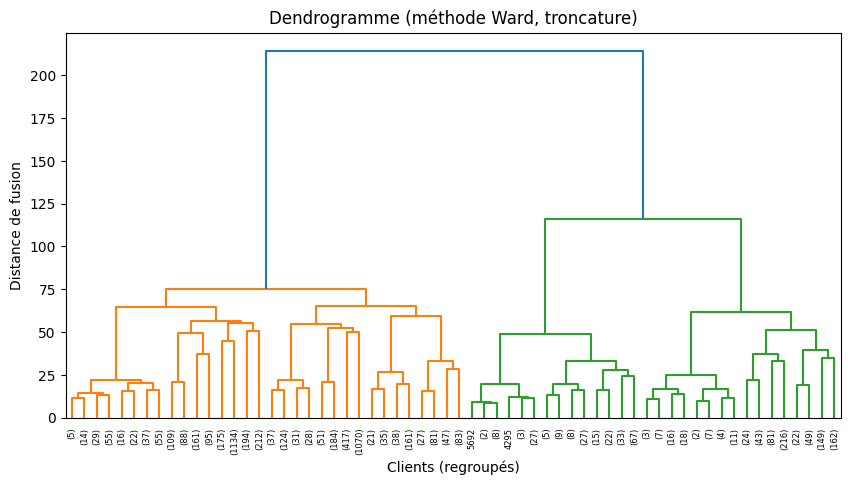

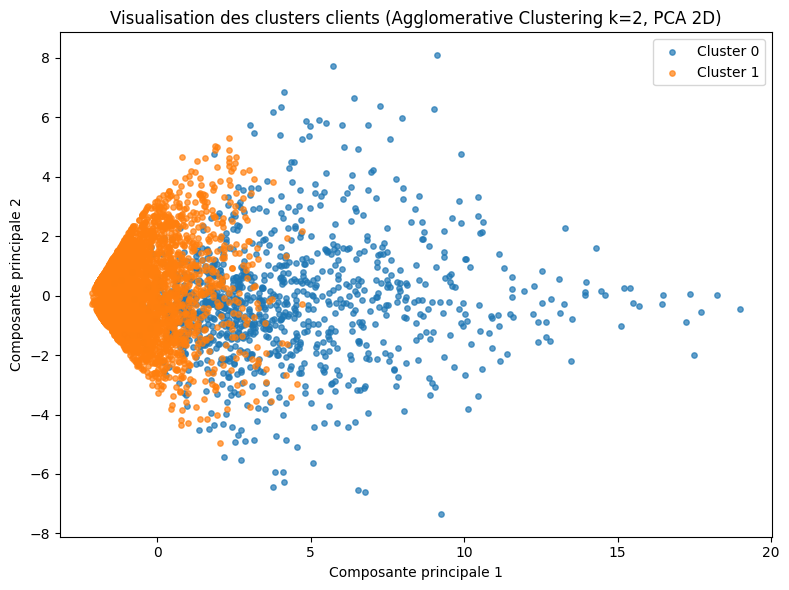

In [23]:


# On utilise les mêmes données log-scalées
Z = linkage(X_scaled_log, method='ward')

# On affiche un dendrogramme tronqué (sinon il y a 5000 clients...)
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)  # affiche les 5 derniers niveaux
plt.title("Dendrogramme (méthode Ward, troncature)")
plt.xlabel("Clients (regroupés)")
plt.ylabel("Distance de fusion")
plt.show()

# Réduction à 2 dimensions (même PCA que pour les données log)
pca_agg = PCA(n_components=2, random_state=42)
X_pca_agg = pca_agg.fit_transform(X_scaled_log)

# Création du DataFrame pour visualisation
df_visu_agg = pd.DataFrame(X_pca_agg, columns=['PC1', 'PC2'])
df_visu_agg['cluster_agg'] = labels_agg_final

# Visualisation
plt.figure(figsize=(8,6))
for c in sorted(df_visu_agg['cluster_agg'].unique()):
    subset = df_visu_agg[df_visu_agg['cluster_agg'] == c]
    plt.scatter(subset['PC1'], subset['PC2'], s=15, alpha=0.7, label=f"Cluster {c}")

plt.title("Visualisation des clusters clients (Agglomerative Clustering k=2, PCA 2D)")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.legend()
plt.tight_layout()
plt.show()


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cluster_agg,,,,,,,,,,,,,,,,,,,,,,,,,
0,480.777236,385.534684,328.339716,459.991689,388.882861,406.627102,437.558186,423.820873,432.934655,537.167698,595.850048,755.944148,635.035816,303.715969,320.391516,404.224741,276.183235,454.766929,414.113772,393.660854,433.656785,597.443196,567.464904,620.526296,208.747246
1,38.396253,32.173681,33.962176,45.553691,39.163203,36.451685,37.868269,31.020552,31.663511,56.221311,85.981028,79.537270,46.088621,52.310380,23.426259,36.041890,37.513943,42.334041,47.499409,39.267246,40.006933,68.300780,92.642754,106.540318,62.178693


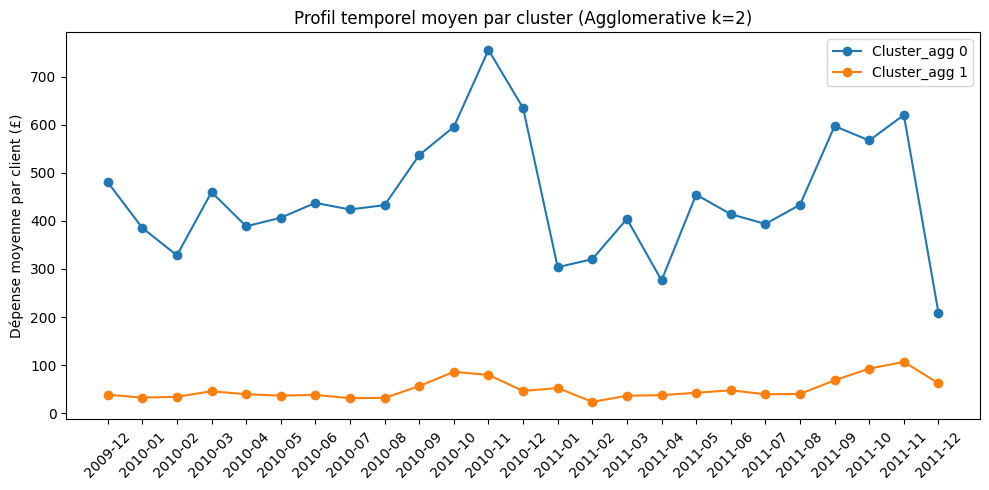

In [24]:
# On rattache le cluster agglomératif aux dépenses mensuelles réelles
client_month_with_cluster_agg = client_month_pivot_raw.copy()
client_month_with_cluster_agg['cluster_agg'] = labels_agg_final

# Moyenne mensuelle par cluster
cluster_time_profile_agg = (
    client_month_with_cluster_agg
    .groupby('cluster_agg')
    .mean()
)

display(cluster_time_profile_agg)

# Visualisation
plt.figure(figsize=(10,5))
for c in cluster_time_profile_agg.index:
    plt.plot(
        cluster_time_profile_agg.columns.astype(str),
        cluster_time_profile_agg.loc[c],
        marker='o',
        label=f"Cluster_agg {c}"
    )

plt.xticks(rotation=45)
plt.ylabel("Dépense moyenne par client (£)")
plt.title("Profil temporel moyen par cluster (Agglomerative k=2)")
plt.legend()
plt.tight_layout()
plt.show()


,InvoiceMonth,cluster_agg,revenue,total_rev,share
0,2009-12,0,500969.880,686654.160,0.729581
1,2009-12,1,185684.280,686654.160,0.270419
2,2010-01,0,401727.141,557319.062,0.720821
3,2010-01,1,155591.921,557319.062,0.279179
4,2010-02,0,342129.984,506371.066,0.675651


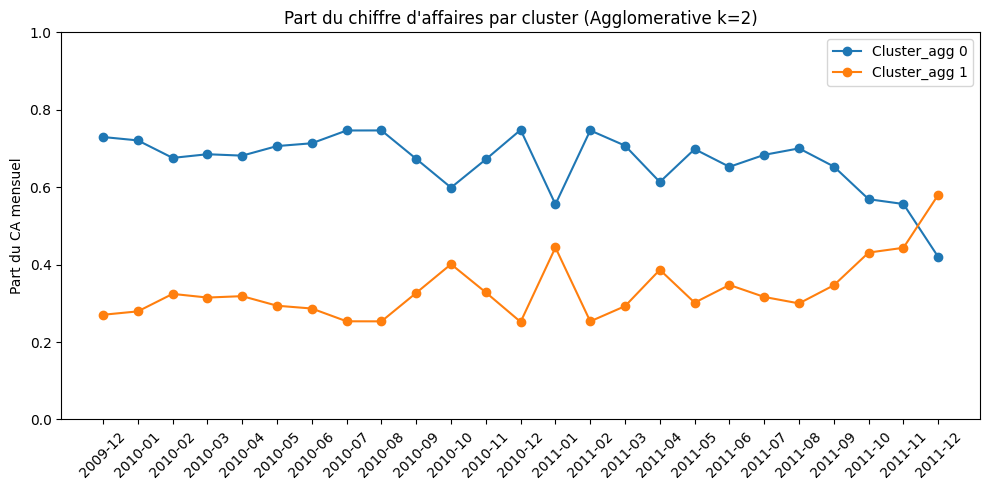

In [25]:
client_month_with_cluster_long_agg = client_month.merge(
    client_clusters_agg,
    on='Customer ID',
    how='left'
)

cluster_evol_agg = (
    client_month_with_cluster_long_agg
    .groupby(['InvoiceMonth', 'cluster_agg'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

total_month_rev_agg = (
    client_month_with_cluster_long_agg
    .groupby('InvoiceMonth')
    .agg(total_rev=('revenue', 'sum'))
    .reset_index()
)

cluster_evol_agg = cluster_evol_agg.merge(total_month_rev_agg, on='InvoiceMonth')
cluster_evol_agg['share'] = cluster_evol_agg['revenue'] / cluster_evol_agg['total_rev']

display(cluster_evol_agg.head())

plt.figure(figsize=(10,5))
for c in sorted(cluster_evol_agg['cluster_agg'].unique()):
    tmp = cluster_evol_agg[cluster_evol_agg['cluster_agg'] == c]
    plt.plot(
        tmp['InvoiceMonth'].astype(str),
        tmp['share'],
        marker='o',
        label=f"Cluster_agg {c}"
    )

plt.ylim(0,1)
plt.xticks(rotation=45)
plt.ylabel("Part du CA mensuel")
plt.title("Part du chiffre d'affaires par cluster (Agglomerative k=2)")
plt.legend()
plt.tight_layout()
plt.show()


In [26]:


#  Remplacer les NaN par 0
data_ts = client_month_pivot_raw.fillna(0).values  # (n_clients, n_mois)

#  Appliquer log(1+x) pour atténuer les valeurs extrêmes
data_ts_log = np.log1p(data_ts)

#  Normaliser chaque série (moyenne=0, variance=1)
scaler_ts = TimeSeriesScalerMeanVariance()
data_ts_norm = scaler_ts.fit_transform(data_ts_log)  # shape: (n_clients, n_mois, 1)

print("Shape des données temporelles normalisées :", data_ts_norm.shape)


Shape des données temporelles normalisées : (5878, 25, 1)


****************************************************DTW**************************************************

In [27]:
from tslearn.clustering import TimeSeriesKMeans

#  Clustering par DTW
n_clusters_dtw = 3

model_dtw = TimeSeriesKMeans(
    n_clusters=n_clusters_dtw,
    metric="dtw",             # Distance dynamique dans le temps
    max_iter=50,
    n_init=2,
    verbose=True,
    random_state=42
)

labels_dtw = model_dtw.fit_predict(data_ts_norm)

# Associer les clusters aux clients
client_clusters_dtw = pd.DataFrame({
    "Customer ID": client_month_pivot_raw.index,
    "cluster_dtw": labels_dtw
})

print("Taille des clusters (DTW) :")
print(client_clusters_dtw['cluster_dtw'].value_counts().sort_index())


Init 1


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    5.2s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.0s
[Parallel(n_jobs

7.839 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.9s
[Parallel(

5.767 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.2s
[Parallel(

5.734 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.1s
[Parallel(

5.730 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.5s
[Parallel(

5.729 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.1s
[Parallel(

5.728 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.2s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.7s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.2s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.9s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.4s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.5s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.8s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    5.6s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    6.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    7.2s
[Parallel(

5.727 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.8s
[Parallel(

5.727 --> 
Init 2


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs

11.474 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.5s
[Parallel(

6.977 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.8s
[Parallel(

6.932 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.5s
[Parallel(

6.880 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    5.1s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    6.6s
[Parallel(

6.825 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.9s
[Parallel(

6.743 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.8s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.9s
[Parallel(

6.714 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    7.4s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    9.6s
[Parallel(

6.694 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.6s
[Parallel(

6.680 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.8s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.3s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    3.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.4s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.3s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.3s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.0s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.9s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.0s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    4.5s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    5.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    6.3s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    7.5s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    9.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:   11.6s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:   12.5s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.6s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    5.3s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    6.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    6.6s
[Parallel(

6.679 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.2s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.4s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.9s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.8s
[Parallel(

6.678 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.1s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.6s
[Parallel(

6.678 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.2s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.7s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.7s
[Parallel(

6.678 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.5s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.9s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.3s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.1s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.6s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.7s
[Parallel(

6.678 --> 

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.8s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.6s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    3.5s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.0s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    4.6s
[Parallel(

6.678 --> 


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1249 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2449 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 3199 tasks      | elapsed:    1.0s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done 4999 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done 6049 tasks      | elapsed:    2.1s
[Parallel(n_jobs=1)]: Done 7199 tasks      | elapsed:    2.5s
[Parallel(n_jobs=1)]: Done 8449 tasks      | elapsed:    3.4s
[Parallel(n_jobs=1)]: Done 9799 tasks      | elapsed:    4.2s
[Parallel(n_jobs=1)]: Done 11249 tasks      | elapsed:    4.8s
[Parallel(n_jobs=1)]: Done 12799 tasks      | elapsed:    5.5s
[Parallel(

Taille des clusters (DTW) :
cluster_dtw
0    1845
1    2031
2    2002
Name: count, dtype: int64


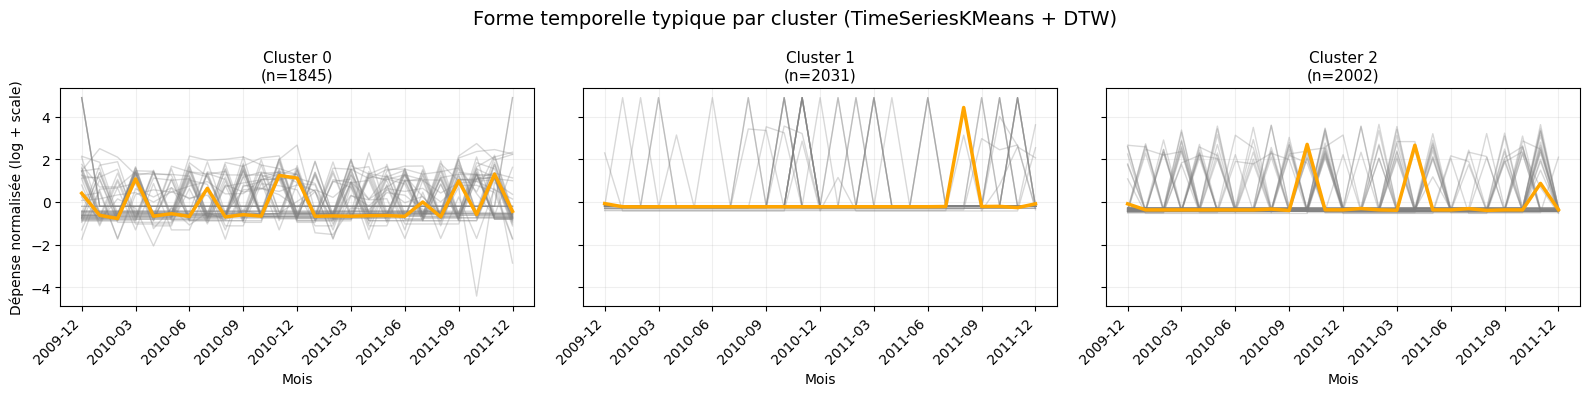

In [28]:


#Récupérer les vrais noms de mois depuis ton pivot
month_labels = client_month_pivot_raw.columns.astype(str).tolist()
time_axis = np.arange(len(month_labels))

n_clusters = n_clusters_dtw
n_samples_per_cluster = 50  # nombre de clients affichés en gris

fig, axes = plt.subplots(1, n_clusters, figsize=(16, 4), sharey=True)

for c in range(n_clusters):
    ax = axes[c]

    # indices des clients appartenant à ce cluster
    idx_c = np.where(labels_dtw == c)[0]

    # échantillon aléatoire pour ne pas surcharger le graphe
    if len(idx_c) <= n_samples_per_cluster:
        sample_idx = idx_c
    else:
        sample_idx = np.random.choice(idx_c, size=n_samples_per_cluster, replace=False)

    # tracer les séries grises
    for idx in sample_idx:
        serie = data_ts_norm[idx].ravel()
        ax.plot(time_axis, serie, color='gray', alpha=0.3, linewidth=1)

    # tracer le centroïde DTW en orange
    centroid = model_dtw.cluster_centers_[c].ravel()
    ax.plot(time_axis, centroid, color='orange', linewidth=2.5)

    # personnalisation du graphique
    ax.set_title(f"Cluster {c}\n(n={len(idx_c)})", fontsize=11)
    ax.grid(True, alpha=0.2)
    
    # afficher seulement quelques mois pour lisibilité
    ax.set_xticks(time_axis[::3])
    ax.set_xticklabels([month_labels[i] for i in time_axis[::3]], rotation=45, ha="right")

    if c == 0:
        ax.set_ylabel("Dépense normalisée (log + scale)")
    ax.set_xlabel("Mois")

plt.suptitle("Forme temporelle typique par cluster (TimeSeriesKMeans + DTW)", fontsize=14)
plt.tight_layout()
plt.show()


Profil temporel moyen (£) par cluster_dtw :


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cluster_dtw,,,,,,,,,,,,,,,,,,,,,,,,,
0,324.690656,255.886055,217.208289,291.959735,247.593887,256.202938,277.864233,257.491398,268.901897,347.798375,409.316986,484.408321,408.927187,218.398959,204.574553,259.505496,190.530006,296.330921,277.307995,260.995079,284.611149,397.926515,418.652699,474.861008,258.403984
1,16.524609,10.837085,14.666130,28.414466,17.257854,17.384648,18.347725,11.020556,10.830359,33.302137,38.884471,35.941443,11.673998,47.149000,8.533200,13.793742,10.588484,14.085982,27.701763,10.858277,15.231477,37.772910,55.159099,50.591979,9.211428
2,26.992218,31.568017,37.879551,51.565185,51.322562,45.945629,44.526893,47.044136,43.018077,61.084096,101.156743,102.700110,53.152517,35.334336,26.157028,44.304710,48.035609,51.576114,46.612468,48.202763,44.605994,70.902688,77.360854,91.381873,11.362153


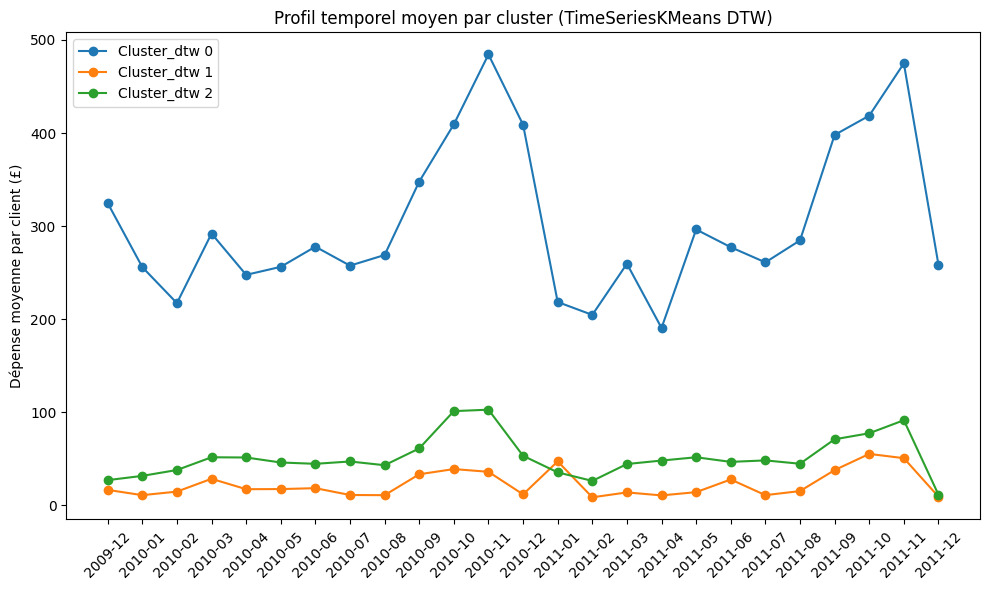

In [29]:


# On repart de la table client_month_pivot_raw = dépenses mensuelles originales (£)
df_dtw_profile = client_month_pivot_raw.copy()
df_dtw_profile['cluster_dtw'] = labels_dtw

# Moyenne par cluster
cluster_time_profile_dtw = (
    df_dtw_profile
    .groupby('cluster_dtw')
    .mean()
)

print("Profil temporel moyen (£) par cluster_dtw :")
display(cluster_time_profile_dtw)

# Plot
plt.figure(figsize=(10,6))
for c in cluster_time_profile_dtw.index:
    plt.plot(
        cluster_time_profile_dtw.columns.astype(str),
        cluster_time_profile_dtw.loc[c],
        marker='o',
        label=f"Cluster_dtw {c}"
    )

plt.xticks(rotation=45)
plt.ylabel("Dépense moyenne par client (£)")
plt.title("Profil temporel moyen par cluster (TimeSeriesKMeans DTW)")
plt.legend()
plt.tight_layout()
plt.show()


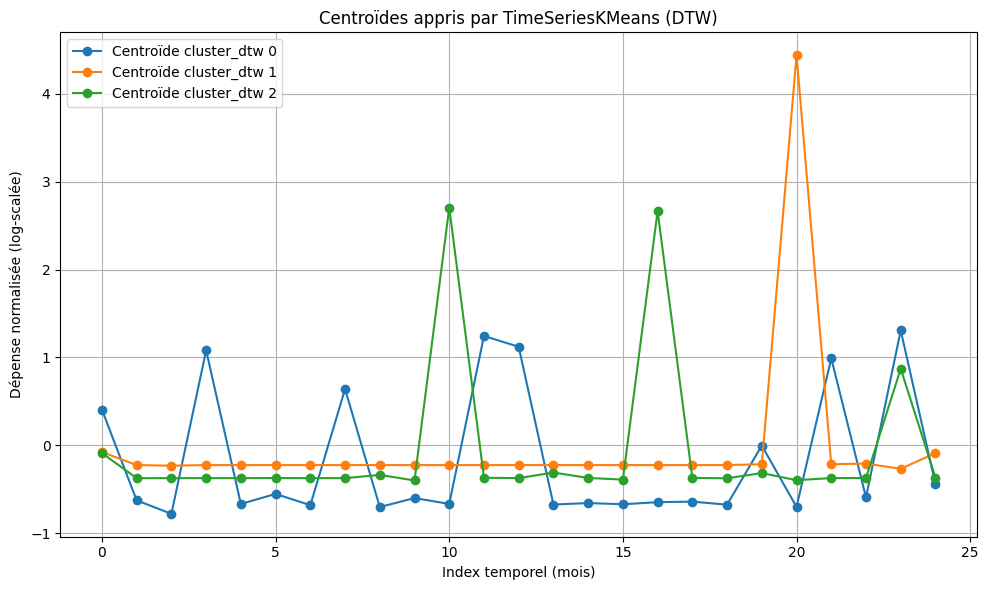

In [30]:
plt.figure(figsize=(10,6))
for c in range(n_clusters_dtw):
    plt.plot(
        model_dtw.cluster_centers_[c].ravel(),
        marker='o',
        label=f"Centroïde cluster_dtw {c}"
    )

plt.title("Centroïdes appris par TimeSeriesKMeans (DTW)")
plt.xlabel("Index temporel (mois)")
plt.ylabel("Dépense normalisée (log-scalée)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Aperçu part du CA par cluster_dtw et par mois :


,InvoiceMonth,cluster_dtw,revenue,total_rev,share
0,2009-12,0,599054.260,686654.160,0.872425
1,2009-12,1,33561.480,686654.160,0.048877
2,2009-12,2,54038.420,686654.160,0.078698
3,2010-01,0,472109.771,557319.062,0.847109
4,2010-01,1,22010.120,557319.062,0.039493


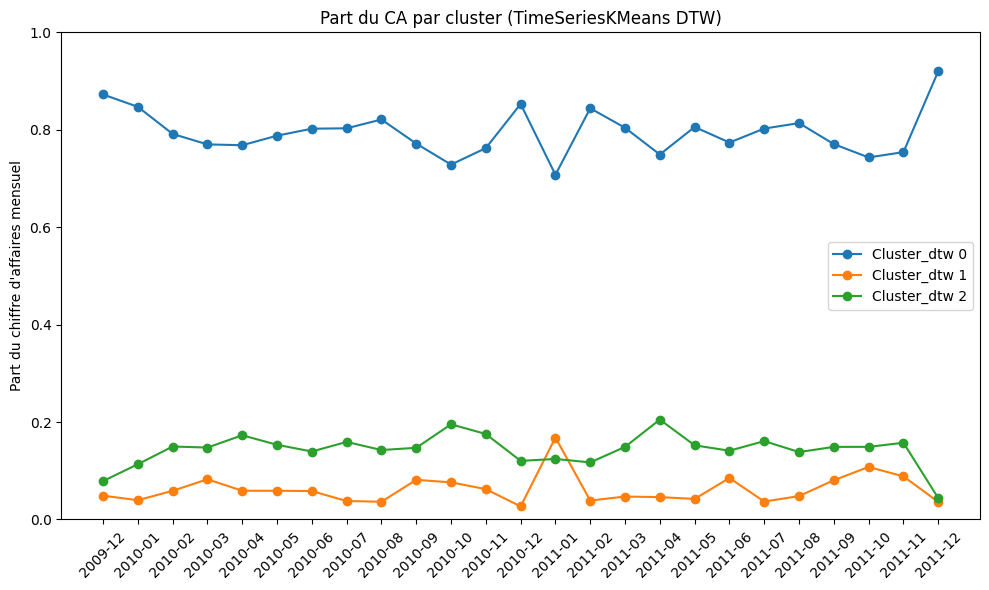

In [31]:
# Construire table longue client-mois avec revenu total
client_month_long = client_month.copy()  # colonnes: Customer ID, InvoiceMonth, revenue

# Ajouter le label du cluster DTW à chaque client
client_month_long = client_month_long.merge(
    client_clusters_dtw,
    on='Customer ID',
    how='left'
)

# Revenu total par cluster_dtw et par mois
cluster_evol_dtw = (
    client_month_long
    .groupby(['InvoiceMonth', 'cluster_dtw'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

# Revenu total du mois (tous clusters combinés)
total_month_rev_dtw = (
    client_month_long
    .groupby('InvoiceMonth')
    .agg(total_rev=('revenue', 'sum'))
    .reset_index()
)

# Ajouter le total pour calculer la part
cluster_evol_dtw = cluster_evol_dtw.merge(total_month_rev_dtw, on='InvoiceMonth')
cluster_evol_dtw['share'] = cluster_evol_dtw['revenue'] / cluster_evol_dtw['total_rev']

print("Aperçu part du CA par cluster_dtw et par mois :")
display(cluster_evol_dtw.head())

# Visualiser la part du CA dans le temps
plt.figure(figsize=(10,6))
for c in sorted(cluster_evol_dtw['cluster_dtw'].unique()):
    tmp = cluster_evol_dtw[cluster_evol_dtw['cluster_dtw'] == c]
    plt.plot(
        tmp['InvoiceMonth'].astype(str),
        tmp['share'],
        marker='o',
        label=f"Cluster_dtw {c}"
    )

plt.ylim(0,1)
plt.xticks(rotation=45)
plt.ylabel("Part du chiffre d'affaires mensuel")
plt.title("Part du CA par cluster (TimeSeriesKMeans DTW)")
plt.legend()
plt.tight_layout()
plt.show()


In [32]:


# 1 Préparation des données
data_ts = client_month_pivot_raw.fillna(0).values
data_ts_log = np.log1p(data_ts)

# Normalisation par série
scaler_ts = TimeSeriesScalerMeanVariance()
data_ts_norm = scaler_ts.fit_transform(data_ts_log)

print("Shape données :", data_ts_norm.shape)

# 2 Clustering KShape
n_clusters_kshape = 3
kshape = KShape(n_clusters=n_clusters_kshape, verbose=True, random_state=42)
labels_kshape = kshape.fit_predict(data_ts_norm)

# 3 Associer les clusters aux clients
client_clusters_kshape = pd.DataFrame({
    "Customer ID": client_month_pivot_raw.index,
    "cluster_kshape": labels_kshape
})

print("Taille des clusters (KShape) :")
print(client_clusters_kshape['cluster_kshape'].value_counts().sort_index())


Shape données : (5878, 25, 1)
0.147 --> 0.137 --> 0.132 --> 0.130 --> 0.131 --> 
Taille des clusters (KShape) :
cluster_kshape
0    1218
1    3053
2    1607
Name: count, dtype: int64


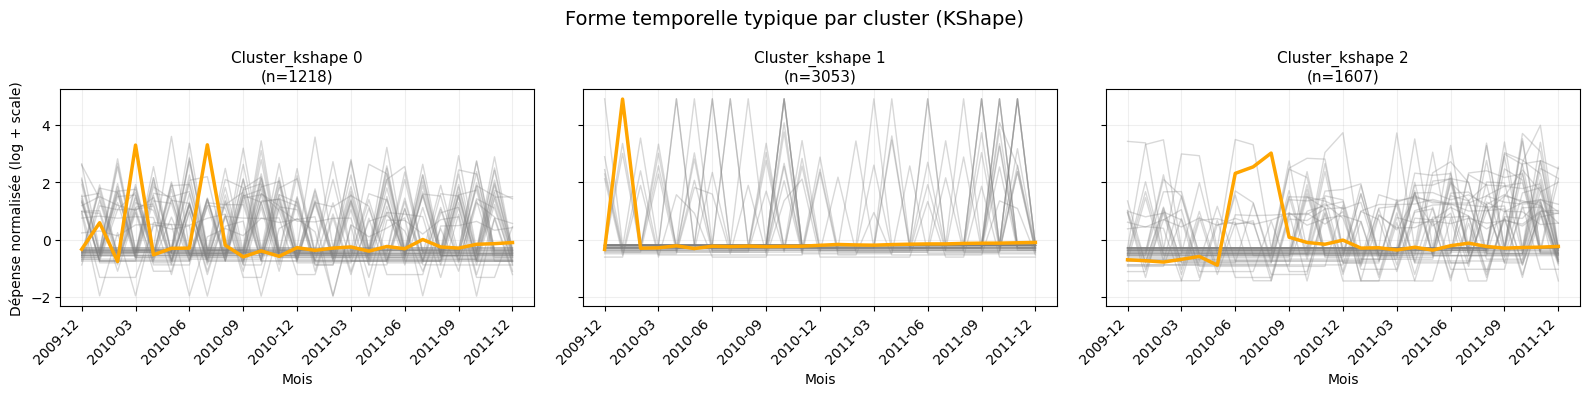

In [33]:


# Récupérer les mois réels comme labels pour l'axe X
month_labels = client_month_pivot_raw.columns.astype(str).tolist()
time_axis = np.arange(len(month_labels))

n_clusters = n_clusters_kshape           # normalement = 3
n_samples_per_cluster = 50               # combien de séries grises on affiche max

fig, axes = plt.subplots(1, n_clusters, figsize=(16, 4), sharey=True)

for c in range(n_clusters):
    ax = axes[c]

    # indices des clients appartenant à ce cluster kshape
    idx_c = np.where(labels_kshape == c)[0]

    # sous-échantillonnage pour ne pas tout afficher
    if len(idx_c) <= n_samples_per_cluster:
        sample_idx = idx_c
    else:
        sample_idx = np.random.choice(idx_c, size=n_samples_per_cluster, replace=False)

    # tracer les séries individuelles en gris
    for idx in sample_idx:
        serie = data_ts_norm[idx].ravel()  # shape (n_mois,)
        ax.plot(
            time_axis,
            serie,
            color='gray',
            alpha=0.3,
            linewidth=1
        )

    # tracer le centroïde du cluster (typique KShape)
    centroid = kshape.cluster_centers_[c].ravel()
    ax.plot(
        time_axis,
        centroid,
        color='orange',
        linewidth=2.5,
        label=f"Centroïde {c}"
    )

    # titre du sous-graph avec la taille du cluster
    ax.set_title(f"Cluster_kshape {c}\n(n={len(idx_c)})", fontsize=11)
    ax.grid(True, alpha=0.2)

    # axe X avec les vrais mois (mais pas tous sinon c'est illisible)
    ax.set_xticks(time_axis[::3])
    ax.set_xticklabels([month_labels[i] for i in time_axis[::3]], rotation=45, ha="right")

    if c == 0:
        ax.set_ylabel("Dépense normalisée (log + scale)")
    ax.set_xlabel("Mois")

plt.suptitle("Forme temporelle typique par cluster (KShape)", fontsize=14)
plt.tight_layout()
plt.show()


Profil temporel moyen (£) par cluster_kshape :


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
cluster_kshape,,,,,,,,,,,,,,,,,,,,,,,,,
0,218.226527,202.481100,157.700002,192.726724,184.577545,190.277652,193.639278,215.313498,204.896888,221.842776,300.909056,284.542011,218.139532,140.432529,135.023038,175.371576,118.148605,193.326305,166.226765,185.276044,158.617718,285.957357,243.107570,259.541248,54.706182
1,53.045804,31.052726,35.035389,58.141779,37.744678,38.157412,34.527894,31.645310,32.500354,54.923004,68.790776,71.459558,48.836266,53.583158,22.346636,32.776443,30.413492,38.362670,39.044537,25.917170,34.066636,49.141320,64.948058,74.182254,75.208264
2,161.111021,134.345433,129.016441,178.818289,158.406497,156.647810,185.314424,144.848643,158.963696,245.009689,286.343827,378.094488,292.346497,146.116266,133.450535,175.377536,144.644039,202.863653,211.292172,183.758351,216.640996,282.833771,339.096049,385.325277,138.125594


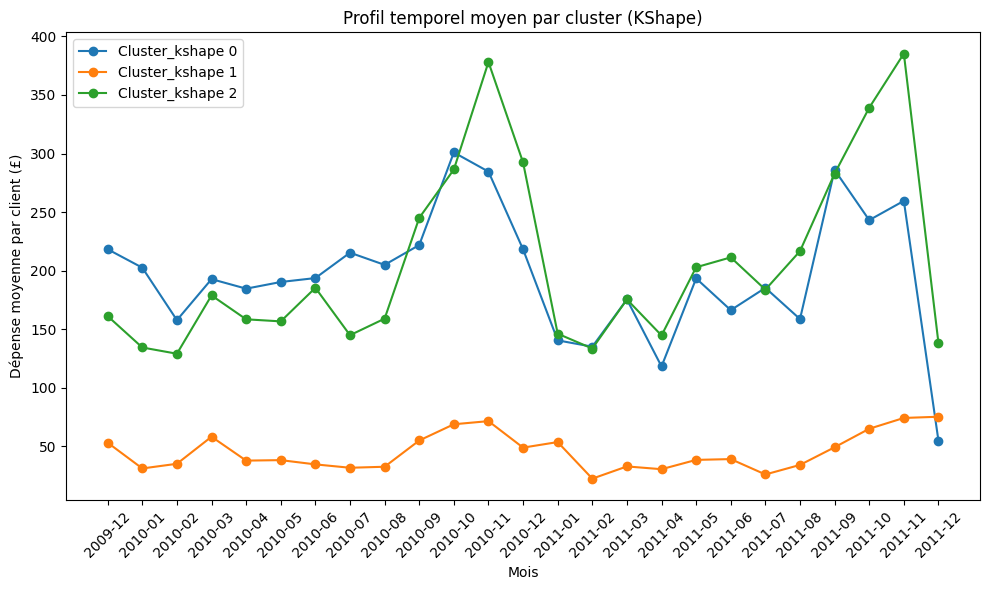

In [34]:


# 1. Calcul du profil moyen par cluster (en £)
df_kshape = client_month_pivot_raw.copy()
df_kshape['cluster_kshape'] = labels_kshape
df_kshape_mean = df_kshape.groupby('cluster_kshape').mean()

print("Profil temporel moyen (£) par cluster_kshape :")
display(df_kshape_mean)

# 2. Préparer les labels X (mois) pour le tracé
col_labels = df_kshape_mean.columns.astype(str)

# 3. Plot des profils temporels moyens
plt.figure(figsize=(10,6))
for c in range(n_clusters_kshape):
    plt.plot(
        col_labels,
        df_kshape_mean.iloc[c],
        marker='o',
        label=f"Cluster_kshape {c}"
    )

plt.xticks(rotation=45)
plt.title("Profil temporel moyen par cluster (KShape)")
plt.xlabel("Mois")
plt.ylabel("Dépense moyenne par client (£)")
plt.legend()
plt.tight_layout()
plt.show()


Aperçu part du CA par cluster_kshape et par mois :


,InvoiceMonth,cluster_kshape,revenue,total_rev,share
0,2009-12,0,265799.910,686654.160,0.387094
1,2009-12,1,161948.840,686654.160,0.235852
2,2009-12,2,258905.410,686654.160,0.377054
3,2010-01,0,246621.980,557319.062,0.442515
4,2010-01,1,94803.971,557319.062,0.170107


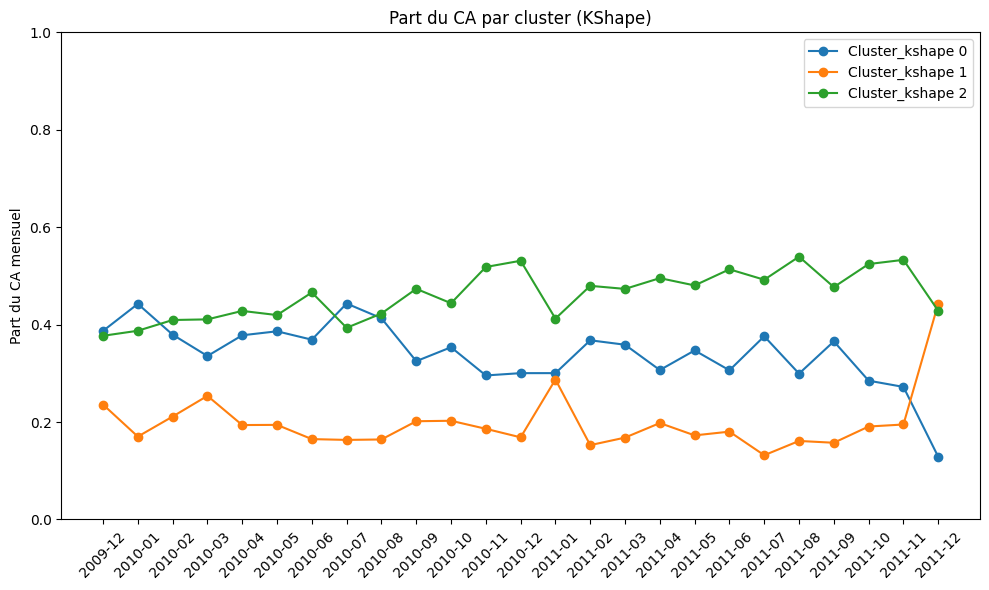

In [35]:


client_month_kshape = client_month.copy()
client_month_kshape = client_month_kshape.merge(
    client_clusters_kshape,
    on="Customer ID",
    how="left"
)

# Somme du CA par cluster_kshape et par mois
cluster_evol_kshape = (
    client_month_kshape
    .groupby(['InvoiceMonth', 'cluster_kshape'])
    .agg(revenue=('revenue', 'sum'))
    .reset_index()
)

# Revenu total mensuel
total_month_rev_kshape = (
    client_month_kshape
    .groupby('InvoiceMonth')
    .agg(total_rev=('revenue', 'sum'))
    .reset_index()
)

# Pourcentage (part du CA par mois)
cluster_evol_kshape = cluster_evol_kshape.merge(total_month_rev_kshape, on='InvoiceMonth')
cluster_evol_kshape['share'] = cluster_evol_kshape['revenue'] / cluster_evol_kshape['total_rev']

print("Aperçu part du CA par cluster_kshape et par mois :")
display(cluster_evol_kshape.head())

# Visualisation
plt.figure(figsize=(10,6))
for c in sorted(cluster_evol_kshape['cluster_kshape'].unique()):
    subset = cluster_evol_kshape[cluster_evol_kshape['cluster_kshape'] == c]
    plt.plot(
        subset['InvoiceMonth'].astype(str),
        subset['share'],
        marker='o',
        label=f"Cluster_kshape {c}"
    )

plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.ylabel("Part du CA mensuel")
plt.title("Part du CA par cluster (KShape)")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
# On part de la table nettoyée existante
df_products = sales.copy()

# On vérifie que les colonnes attendues existent
expected_cols = ['Invoice', 'StockCode', 'Quantity', 'Price', 'InvoiceDate', 'InvoiceMonth', 'TotalPrice']
missing_cols = [c for c in expected_cols if c not in df_products.columns]
if missing_cols:
    print(" Colonnes manquantes :", missing_cols)
else:
    print(" Toutes les colonnes nécessaires sont présentes.")

# ---------- A. Transactions par facture (pour l'embedding)
transactions_series = (
    df_products
    .groupby('Invoice')['StockCode']
    .apply(list)
)

transactions = transactions_series.tolist()

print(f"\n Nombre de paniers (transactions) : {len(transactions)}")
print("Exemple d'un panier :", transactions[0][:10] if len(transactions) > 0 else [])

# ---------- B. Série temporelle de ventes par produit (pour la saisonnalité)
product_month_pivot = (
    df_products
    .groupby(['StockCode', 'InvoiceMonth'])['TotalPrice']
    .sum()
    .unstack(fill_value=0)
    .sort_index(axis=1)  # ordonner les mois
)

print(f"\n Shape du pivot produit × mois : {product_month_pivot.shape}")
display(product_month_pivot.head(10))


 Toutes les colonnes nécessaires sont présentes.

 Nombre de paniers (transactions) : 36969
Exemple d'un panier : [85048, '79323P', '79323W', 22041, 21232, 22064, 21871, 21523]

 Shape du pivot produit × mois : (4631, 25)


InvoiceMonth,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
StockCode,,,,,,,,,,,,,,,,,,,,,,,,,
10002,181.05,245.65,216.75,480.66,838.75,1064.53,372.58,401.55,441.85,184.45,774.90,740.25,309.40,286.45,42.50,19.55,160.65,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10080,3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00,5.10,0.00,0.85,0.00,0.00,1.70,0.00,0.00,0.00,18.72,9.36,23.40,23.40,2.34,35.49,0.00
10109,1.68,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10120,22.26,6.30,0.00,14.28,12.60,0.84,6.30,0.63,0.00,1.89,14.91,15.75,6.51,0.00,6.30,6.09,0.00,0.63,0.00,1.05,7.35,2.10,2.10,10.29,1.26
10125,105.40,0.00,35.70,73.10,17.00,17.00,53.55,89.25,0.00,55.25,84.15,104.55,115.10,67.20,0.00,95.20,69.70,90.95,11.05,149.60,72.25,178.50,42.50,52.70,22.10
10133,130.05,117.35,81.60,29.75,36.95,66.70,25.50,44.20,55.25,36.55,88.40,59.50,106.80,42.10,31.45,70.55,63.75,28.05,201.06,278.04,268.80,81.06,0.00,0.00,0.00
10134,52.50,229.50,42.50,80.00,25.00,12.50,21.25,16.25,152.80,2.50,35.00,35.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
10135,133.75,60.00,946.95,125.00,66.25,147.25,91.25,66.25,92.50,53.75,103.75,377.25,230.65,217.80,274.15,96.45,37.50,10.00,68.75,221.25,171.00,94.68,100.77,207.76,94.68
10138,70.14,5.46,15.12,5.46,7.56,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [37]:


# 1. Partons des ventes nettoyées
prod_info = (
    sales[['StockCode', 'Description']]
    .dropna(subset=['StockCode', 'Description'])
    .drop_duplicates(subset=['StockCode'])
    .copy()
)

# Nettoyage simple du texte (optionnel mais utile)
prod_info['Description_clean'] = (
    prod_info['Description']
    .str.lower()
    .str.replace(r'[^a-z0-9\s]', ' ', regex=True)   # enlever les caractères spéciaux
    .str.replace(r'\s+', ' ', regex=True)           # espaces multiples -> simple espace
    .str.strip()
)
# Suppression des produits sans description (ou uniquement espaces)
prod_info = prod_info[prod_info['Description'].notna()]
prod_info = prod_info[prod_info['Description'].str.strip() != ""]

print("Nombre de produits restants après suppression :", len(prod_info))


print("Nombre total de produits uniques (après nettoyage desc):", prod_info.shape[0])
print("\nExemple produits :")
display(prod_info.head(10))


Nombre de produits restants après suppression : 4631
Nombre total de produits uniques (après nettoyage desc): 4631

Exemple produits :


,StockCode,Description,Description_clean
0,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,15cm christmas glass ball 20 lights
1,79323P,PINK CHERRY LIGHTS,pink cherry lights
2,79323W,WHITE CHERRY LIGHTS,white cherry lights
3,22041,"RECORD FRAME 7"" SINGLE SIZE",record frame 7 single size
4,21232,STRAWBERRY CERAMIC TRINKET BOX,strawberry ceramic trinket box
5,22064,PINK DOUGHNUT TRINKET POT,pink doughnut trinket pot
6,21871,SAVE THE PLANET MUG,save the planet mug
7,21523,FANCY FONT HOME SWEET HOME DOORMAT,fancy font home sweet home doormat
8,22350,CAT BOWL,cat bowl
9,22349,"DOG BOWL , CHASING BALL DESIGN",dog bowl chasing ball design


In [38]:


model_text = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# 2 Encoder toutes les descriptions nettoyées
print(" Encodage des descriptions produits...")
desc_vectors = model_text.encode(
    prod_info['Description_clean'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True,
    batch_size=64
)

# 3 Convertir en DataFrame pour inspection
text_embeddings = pd.DataFrame(
    desc_vectors,
    index=prod_info['StockCode'],
    columns=[f"text_dim_{i}" for i in range(desc_vectors.shape[1])]
)

print("\n Shape des embeddings texte :", text_embeddings.shape)
display(text_embeddings.head())

# Vérification rapide de similarités sémantiques
# (facultatif mais utile pour test)
from sklearn.metrics.pairwise import cosine_similarity

test_idx = 0  # on prend le premier produit
similarities = cosine_similarity(
    [desc_vectors[test_idx]],
    desc_vectors
)[0]
top_similar = np.argsort(similarities)[::-1][1:6]
print("\nProduit de référence :", prod_info.iloc[test_idx]['Description'])
print("Produits sémantiquement proches :")
for idx in top_similar:
    print("-", prod_info.iloc[idx]['Description'])


 Encodage des descriptions produits...


Batches:   0%|          | 0/73 [00:00<?, ?it/s]


 Shape des embeddings texte : (4631, 384)


,text_dim_0,text_dim_1,text_dim_2,text_dim_3,text_dim_4,text_dim_5,text_dim_6,text_dim_7,text_dim_8,text_dim_9,text_dim_10,text_dim_11,text_dim_12,text_dim_13,text_dim_14,text_dim_15,text_dim_16,text_dim_17,text_dim_18,text_dim_19,text_dim_20,text_dim_21,text_dim_22,text_dim_23,text_dim_24,text_dim_25,text_dim_26,text_dim_27,text_dim_28,text_dim_29,text_dim_30,text_dim_31,text_dim_32,text_dim_33,text_dim_34,text_dim_35,text_dim_36,text_dim_37,text_dim_38,text_dim_39,text_dim_40,text_dim_41,text_dim_42,text_dim_43,text_dim_44,text_dim_45,text_dim_46,text_dim_47,text_dim_48,text_dim_49,text_dim_50,text_dim_51,text_dim_52,text_dim_53,text_dim_54,text_dim_55,text_dim_56,text_dim_57,text_dim_58,text_dim_59,text_dim_60,text_dim_61,text_dim_62,text_dim_63,text_dim_64,text_dim_65,text_dim_66,text_dim_67,text_dim_68,text_dim_69,text_dim_70,text_dim_71,text_dim_72,text_dim_73,text_dim_74,text_dim_75,text_dim_76,text_dim_77,text_dim_78,text_dim_79,text_dim_80,text_dim_81,text_dim_82,text_dim_83,text_dim_84,text_dim_85,text_dim_86,text_dim_87,text_dim_88,text_dim_89,text_dim_90,text_dim_91,text_dim_92,text_dim_93,text_dim_94,text_dim_95,text_dim_96,text_dim_97,text_dim_98,text_dim_99,text_dim_100,text_dim_101,text_dim_102,text_dim_103,text_dim_104,text_dim_105,text_dim_106,text_dim_107,text_dim_108,text_dim_109,text_dim_110,text_dim_111,text_dim_112,text_dim_113,text_dim_114,text_dim_115,text_dim_116,text_dim_117,text_dim_118,text_dim_119,text_dim_120,text_dim_121,text_dim_122,text_dim_123,text_dim_124,text_dim_125,text_dim_126,text_dim_127,text_dim_128,text_dim_129,text_dim_130,text_dim_131,text_dim_132,text_dim_133,text_dim_134,text_dim_135,text_dim_136,text_dim_137,text_dim_138,text_dim_139,text_dim_140,text_dim_141,text_dim_142,text_dim_143,text_dim_144,text_dim_145,text_dim_146,text_dim_147,text_dim_148,text_dim_149,text_dim_150,text_dim_151,text_dim_152,text_dim_153,text_dim_154,text_dim_155,text_dim_156,text_dim_157,text_dim_158,text_dim_159,text_dim_160,text_dim_161,text_dim_162,text_dim_163,text_dim_164,text_dim_165,text_dim_166,text_dim_167,text_dim_168,text_dim_169,text_dim_170,text_dim_171,text_dim_172,text_dim_173,text_dim_174,text_dim_175,text_dim_176,text_dim_177,text_dim_178,text_dim_179,text_dim_180,text_dim_181,text_dim_182,text_dim_183,text_dim_184,text_dim_185,text_dim_186,text_dim_187,text_dim_188,text_dim_189,text_dim_190,text_dim_191,text_dim_192,text_dim_193,text_dim_194,text_dim_195,text_dim_196,text_dim_197,text_dim_198,text_dim_199,text_dim_200,text_dim_201,text_dim_202,text_dim_203,text_dim_204,text_dim_205,text_dim_206,text_dim_207,text_dim_208,text_dim_209,text_dim_210,text_dim_211,text_dim_212,text_dim_213,text_dim_214,text_dim_215,text_dim_216,text_dim_217,text_dim_218,text_dim_219,text_dim_220,text_dim_221,text_dim_222,text_dim_223,text_dim_224,text_dim_225,text_dim_226,text_dim_227,text_dim_228,text_dim_229,text_dim_230,text_dim_231,text_dim_232,text_dim_233,text_dim_234,text_dim_235,text_dim_236,text_dim_237,text_dim_238,text_dim_239,text_dim_240,text_dim_241,text_dim_242,text_dim_243,text_dim_244,text_dim_245,text_dim_246,text_dim_247,text_dim_248,text_dim_249,text_dim_250,text_dim_251,text_dim_252,text_dim_253,text_dim_254,text_dim_255,text_dim_256,text_dim_257,text_dim_258,text_dim_259,text_dim_260,text_dim_261,text_dim_262,text_dim_263,text_dim_264,text_dim_265,text_dim_266,text_dim_267,text_dim_268,text_dim_269,text_dim_270,text_dim_271,text_dim_272,text_dim_273,text_dim_274,text_dim_275,text_dim_276,text_dim_277,text_dim_278,text_dim_279,text_dim_280,text_dim_281,text_dim_282,text_dim_283,text_dim_284,text_dim_285,text_dim_286,text_dim_287,text_dim_288,text_dim_289,text_dim_290,text_dim_291,text_dim_292,text_dim_293,text_dim_294,text_dim_295,text_dim_296,text_dim_297,text_dim_298,text_dim_299,text_dim_300,text_dim_301,text_dim_302,text_dim_303,text_dim_304,text_dim_305,text_dim_306,text_dim_307,text_dim_308,text_dim_309,text_dim_310,text_dim_311,text_dim_312,text_dim_313,text_dim_314,text_dim_315,t


Produit de référence : 15CM CHRISTMAS GLASS BALL 20 LIGHTS
Produits sémantiquement proches :
- MOSAIC GLASS BALL CANDLEHOLDER
- LARGE HANGING GLASS+ZINC LANTERN
- GLASS SPHERE CANDLE STAND LARGE 
- GLASS STAR FROSTED T-LIGHT HOLDER
- LIGHT PINK FLOCK GLASS CANDLEHOLDER


In [39]:


# 1 Préparation des "phrases" de produits par facture
baskets = (
    sales.groupby("Invoice")["StockCode"]
    .apply(list)
    .tolist()
)

print(f"Nombre total de paniers (transactions) : {len(baskets)}")
print("Exemple de panier :", baskets[0][:10])

# 2 Entraînement du modèle Word2Vec
model_w2v = Word2Vec(
    sentences=baskets,
    vector_size=70,      # taille de l’embedding
    window=5,
    min_count=2,
    workers=4,
    sg=1,                # skip-gram (meilleur pour relations rares)
    epochs=15,
    seed=42
)

# 3 Création du DataFrame d'embeddings
w2v_embeddings = pd.DataFrame(
    [model_w2v.wv[key] for key in model_w2v.wv.key_to_index],
    index=model_w2v.wv.key_to_index.keys(),
    columns=[f"w2v_dim_{i}" for i in range(model_w2v.vector_size)]
)

print("\n Shape des embeddings Word2Vec :", w2v_embeddings.shape)
display(w2v_embeddings.head())

# Trouver l'intersection des produits connus par Word2Vec ET présents dans prod_info
products_in_both = list(
    set(w2v_embeddings.index.astype(str))
    .intersection(set(prod_info['StockCode'].astype(str)))
)

print("Nombre de produits communs texte + co-achat :", len(products_in_both))

# On prend le premier produit de cette intersection comme référence
ref_prod = next(
    (p for p in products_in_both if p in model_w2v.wv.key_to_index),
    None
)

if ref_prod is None:
    raise ValueError("Aucun produit du croisement n'est présent dans le vocabulaire Word2Vec.")
print("Produit choisi pour le test de similarité co-achat :", ref_prod)

# Récupérer la description du produit de réf
ref_desc = prod_info.loc[prod_info['StockCode'].astype(str)==ref_prod, 'Description'].values[0]
print("\nProduit de référence :", ref_desc)

print("\nProduits co-achetés similaires :")
for prod, sim in model_w2v.wv.most_similar(ref_prod, topn=5):
    # On essaie de retrouver leur description
    desc_match = prod_info.loc[prod_info['StockCode'].astype(str)==prod, 'Description'].values
    desc_txt = desc_match[0] if len(desc_match) > 0 else "(description inconnue)"
    print(f"- {prod} : {desc_txt}  (similarité {sim:.2f})")



Nombre total de paniers (transactions) : 36969
Exemple de panier : [85048, '79323P', '79323W', 22041, 21232, 22064, 21871, 21523]

 Shape des embeddings Word2Vec : (4509, 70)


,w2v_dim_0,w2v_dim_1,w2v_dim_2,w2v_dim_3,w2v_dim_4,w2v_dim_5,w2v_dim_6,w2v_dim_7,w2v_dim_8,w2v_dim_9,w2v_dim_10,w2v_dim_11,w2v_dim_12,w2v_dim_13,w2v_dim_14,w2v_dim_15,w2v_dim_16,w2v_dim_17,w2v_dim_18,w2v_dim_19,w2v_dim_20,w2v_dim_21,w2v_dim_22,w2v_dim_23,w2v_dim_24,w2v_dim_25,w2v_dim_26,w2v_dim_27,w2v_dim_28,w2v_dim_29,w2v_dim_30,w2v_dim_31,w2v_dim_32,w2v_dim_33,w2v_dim_34,w2v_dim_35,w2v_dim_36,w2v_dim_37,w2v_dim_38,w2v_dim_39,w2v_dim_40,w2v_dim_41,w2v_dim_42,w2v_dim_43,w2v_dim_44,w2v_dim_45,w2v_dim_46,w2v_dim_47,w2v_dim_48,w2v_dim_49,w2v_dim_50,w2v_dim_51,w2v_dim_52,w2v_dim_53,w2v_dim_54,w2v_dim_55,w2v_dim_56,w2v_dim_57,w2v_dim_58,w2v_dim_59,w2v_dim_60,w2v_dim_61,w2v_dim_62,w2v_dim_63,w2v_dim_64,w2v_dim_65,w2v_dim_66,w2v_dim_67,w2v_dim_68,w2v_dim_69
85123A,-0.155851,0.394958,-0.169216,-0.044362,0.153698,0.628250,0.052880,-0.081592,0.047257,-0.235017,-0.028703,0.055177,-0.033441,0.072916,-0.121338,0.368197,0.358140,-0.060497,-0.125455,-0.062086,-0.132714,-0.093413,0.125855,0.133015,0.160899,0.011523,0.193286,-0.037592,-0.307376,-0.297390,0.083350,0.034538,-0.241465,0.066497,-0.338982,-0.313713,0.123066,0.519468,0.112787,0.141436,0.223511,0.075500,-0.013333,-0.095804,0.025697,0.088117,0.113605,-0.022758,0.148093,0.295404,-0.120445,-0.047757,-0.321388,0.038650,0.173971,-0.211988,0.073217,-0.271740,-0.064897,-0.285406,0.068366,-0.067817,-0.123206,0.177352,0.102772,-0.124016,0.240828,0.360122,0.117857,-0.412255
22423,0.239042,0.077562,0.134855,0.046821,0.007359,0.150254,-0.075623,0.188693,0.330728,-0.104260,-0.057734,-0.085745,-0.379201,-0.001998,-0.032327,0.197195,0.520349,-0.121060,-0.340166,-0.066889,0.061151,0.097673,0.543385,-0.091162,0.299896,-0.049202,0.124659,0.227484,-0.213212,-0.361289,-0.113737,0.402276,0.007877,0.262985,0.152274,-0.275308,-0.198190,0.287970,-0.002842,0.009967,0.500594,0.141178,0.177396,-0.231570,0.396812,-0.337009,-0.177525,-0.019284,0.119429,0.072168,-0.195319,-0.026767,-0.265471,-0.354768,0.207745,-0.400669,-0.019290,-0.434931,-0.322858,-0.313852,-0.357162,-0.297515,-0.182820,0.114723,0.009899,0.247551,0.329170,-0.072956,0.136249,0.179403
85099B,0.110747,0.312611,0.161569,0.321595,0.505674,0.535973,-0.593068,0.263116,0.046371,0.054986,0.410762,0.431149,-0.082963,-0.395989,-0.016388,0.086219,0.290098,0.327353,-0.351606,0.060133,-0.454591,-0.436849,0.055665,-0.119692,0.057782,0.095119,-0.254782,0.012072,-0.078040,-0.367633,0.429220,-0.244305,0.165256,0.131317,-0.008358,0.135502,-0.289259,0.312202,-0.210732,0.310085,0.498082,0.288335,0.179564,-0.035932,0.149037,-0.420251,0.217776,0.176529,-0.013545,-0.094009,-0.267655,0.268065,0.108440,0.050646,0.063002,-0.614673,0.246091,-0.310178,0.074174,-0.200549,-0.216450,-0.184258,0.064204,0.721118,0.119523,-0.132964,0.494529,0.306342,-0.157154,0.379797
84879,-0.200826,0.268937,0.060389,-0.196349,0.393378,0.483290,-0.089572,0.034000,0.124590,-0.158808,0.174052,0.039808,-0.092189,0.026761,-0.108826,0.040632,0.121514,0.019997,-0.112462,0.181289,-0.284200,0.025798,-0.008908,-0.186280,0.102914,0.106889,0.309431,0.112393,-0.446138,-0.268963,-0.263487,0.132265,-0.187587,0.127508,-0.169580,-0.594663,-0.052844,0.296101,-0.146857,-0.407039,0.030599,0.127375,-0.248479,-0.579762,0.389246,-0.469347,-0.112635,-0.023641,0.393645,0.219010,-0.091194,-0.082163,-0.436196,-0.112572,0.074027,-0.290359,0.007459,-0.304711,0.030041,-0.190686,0.109153,-0.337020,0.149988,0.262881,-0.188184,-0.015699,0.200935,0.129581,0.074972,-0.295079
20725,-0.091375,0.169458,0.520127,0.107046,0.443149,0.559177,-0.327729,0.041420,0.243654,0.077590,0.204585,0.097109,-0.120429,-0.204397,-0.207889,0.086995,0.643774,-0.022509,-0.434086,-0.461514,-0.461181,-0.163013,-0.288684,-0.104317,-0.218988,0.024312,-0.365864,-0.185731,-0.229324,-0.137861,0.252328,-0.067836,0.050014,0.277814,-0.485627,0.269804,-0.305193,-0.039974,0.298849,0.348345,0.508825,0.124100,0.114186,0.026012,0.662726,0.147711,-0.048592,0.187264,-0.003339,0.699923,-0.239894,-0.013219,0.093212,0.325506,0.266332,-0.461449,0.409845,-0.541185,0.342024

Nombre de produits communs texte + co-achat : 4509
Produit choisi pour le test de similarité co-achat : 72799B

Produit de référence : PURPLE PILLAR CANDLE BLACK FLOCK

Produits co-achetés similaires :
- 72740A : LARGE STRAWBERRY CHOCOLATE CANDLE  (similarité 0.88)
- 72772 : (description inconnue)  (similarité 0.82)
- 72750D : F.FAIRY S/3 CANDLE/GLASS  (similarité 0.81)
- 72799A : BLACK PILLAR CANDLE SILVER FLOCK  (similarité 0.80)
- 72799D : BLUE PILLAR CANDLE SILVER FLOCK  (similarité 0.78)


In [40]:
# On repart de product_month_pivot qu'on avait construit
# Index = StockCode ; Colonnes = InvoiceMonth ; Valeurs = TotalPrice mensuel

prod_time = product_month_pivot.copy()

# Colonnes mois sous forme texte pour lecture humaine
month_cols = prod_time.columns.astype(str).tolist()

# 1. Total généré par produit sur toute la période
total_revenue = prod_time.sum(axis=1)

# 2. Mois du pic de vente (celui où le CA est max)
peak_month_idx = prod_time.values.argmax(axis=1)
peak_month = [month_cols[i] for i in peak_month_idx]

# 3. Valeur max / moyenne (saisonnalité extrême)
peak_value = prod_time.max(axis=1)
mean_value = prod_time.replace(0, np.nan).mean(axis=1).fillna(0)
peak_ratio = peak_value / (mean_value + 1e-9)

# 4. Mesure de concentration des ventes dans le temps :
#    - On convertit la série temporelle en distribution de probas
#    - Puis on mesure l'entropie
proportions = prod_time.div(prod_time.sum(axis=1).replace(0, np.nan), axis=0).fillna(0)

entropy = -(proportions * np.log(proportions + 1e-12)).sum(axis=1)  # entropie par produit
entropy_max = np.log(prod_time.shape[1])  # log(nb_mois)
concentration = 1 - (entropy / entropy_max)
# -> proche de 1 : très concentré sur quelques mois (cadeau saison)
# -> proche de 0 : vendu toute l'année

seasonality_features = pd.DataFrame({
    'StockCode': prod_time.index.astype(str),
    'total_revenue': total_revenue,
    'peak_month': peak_month,
    'peak_ratio': peak_ratio,
    'concentration': concentration
}).set_index('StockCode')

print(" Shape des features temporelles produits :", seasonality_features.shape)
display(seasonality_features.head())

# Juste pour feeling business :
# Top produits ULTRA saisonniers = très concentrés
top_seasonal = seasonality_features.sort_values('concentration', ascending=False).head(10)
print("\n Produits les plus saisonniers (concentration élevée) :")
for sc in top_seasonal.index:
    desc_match = prod_info.loc[prod_info['StockCode'].astype(str)==sc, 'Description'].values
    desc_txt = desc_match[0] if len(desc_match)>0 else "(desc inconnue)"
    print(f"- {sc} | {desc_txt} | mois pic = {seasonality_features.loc[sc,'peak_month']}")


 Shape des features temporelles produits : (4631, 4)


,total_revenue,peak_month,peak_ratio,concentration
StockCode,,,,
10002,6761.52,2010-05,2.676471,0.200770
10080,124.61,2011-11,3.132895,0.411161
10109,1.68,2009-12,1.000000,1.000000
10120,139.44,2009-12,3.192771,0.186194
10125,1601.80,2011-09,2.451617,0.092284



 Produits les plus saisonniers (concentration élevée) :
- TEST002 | This is a test product. | mois pic = 2009-12
- 47556 | SET/2 SPOTTY + ROSE TEA TOWELS  | mois pic = 2009-12
- 72487 | ROSES WHITE ROUND CANDLE | mois pic = 2009-12
- 21480 | PINK STRIPE HOT WATER BOTTLE | mois pic = 2009-12
- 48179 | DOOR MAT SWEET HOME | mois pic = 2009-12
- 48175 | DOOR MAT CAMOUFLAGE | mois pic = 2009-12
- 20891 | LARGE GLASS ROSE SCENTED CANDLE  | mois pic = 2010-01
- 20890 | SMALL GLASS ROSE SCENTED CANDLE | mois pic = 2010-01
- 47569 | ENGLISH ROSE DESIGN SHOPPING BAG | mois pic = 2009-12
- 20887 | BOX OF 6 PEBBLE CANDLES | mois pic = 2009-12


In [41]:


# 1 Harmoniser les index en string
text_emb = text_embeddings.copy()
text_emb.index = text_emb.index.astype(str)

w2v_emb = w2v_embeddings.copy()
w2v_emb.index = w2v_emb.index.astype(str)

season_feat = seasonality_features.copy()
season_feat.index = season_feat.index.astype(str)

# 2 Garder uniquement les produits présents dans TOUTES les sources
common_products = (
    set(text_emb.index)
    .intersection(set(w2v_emb.index))
    .intersection(set(season_feat.index))
)
common_products = list(common_products)  # ✅ correction ici

print("Nombre de produits utilisables (toutes infos dispo) :", len(common_products))

text_emb_common = text_emb.loc[common_products].sort_index()
w2v_emb_common   = w2v_emb.loc[common_products].sort_index()
season_feat_common = season_feat.loc[common_products].sort_index()

# 3 Encodage du mois de pic (peak_month)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
peak_month_encoded = ohe.fit_transform(season_feat_common[['peak_month']])

peak_month_cols = [f"peak_{cat}" for cat in ohe.categories_[0]]
peak_month_df = pd.DataFrame(
    peak_month_encoded,
    index=season_feat_common.index,
    columns=peak_month_cols
)

# 4 Construire le bloc numérique des features temporelles
season_numeric = pd.concat([
    season_feat_common[['total_revenue','peak_ratio','concentration']],
    peak_month_df
], axis=1)

print("Shape season_numeric :", season_numeric.shape)
print("Shape text_emb_common :", text_emb_common.shape)
print("Shape w2v_emb_common :", w2v_emb_common.shape)

# 5 Concat finale : texte + co-achat + temps
full_feature_matrix = pd.concat(
    [text_emb_common, w2v_emb_common, season_numeric],
    axis=1
)

print("Shape finale du vecteur produit combiné :", full_feature_matrix.shape)
display(full_feature_matrix.head())

# 6 Standardisation
scaler = StandardScaler()
full_feature_scaled = scaler.fit_transform(full_feature_matrix)

print("\n OK: full_feature_scaled prêt pour clustering.")


Nombre de produits utilisables (toutes infos dispo) : 4509
Shape season_numeric : (4509, 28)
Shape text_emb_common : (4509, 384)
Shape w2v_emb_common : (4509, 70)
Shape finale du vecteur produit combiné : (4509, 482)


,text_dim_0,text_dim_1,text_dim_2,text_dim_3,text_dim_4,text_dim_5,text_dim_6,text_dim_7,text_dim_8,text_dim_9,text_dim_10,text_dim_11,text_dim_12,text_dim_13,text_dim_14,text_dim_15,text_dim_16,text_dim_17,text_dim_18,text_dim_19,text_dim_20,text_dim_21,text_dim_22,text_dim_23,text_dim_24,text_dim_25,text_dim_26,text_dim_27,text_dim_28,text_dim_29,text_dim_30,text_dim_31,text_dim_32,text_dim_33,text_dim_34,text_dim_35,text_dim_36,text_dim_37,text_dim_38,text_dim_39,text_dim_40,text_dim_41,text_dim_42,text_dim_43,text_dim_44,text_dim_45,text_dim_46,text_dim_47,text_dim_48,text_dim_49,text_dim_50,text_dim_51,text_dim_52,text_dim_53,text_dim_54,text_dim_55,text_dim_56,text_dim_57,text_dim_58,text_dim_59,text_dim_60,text_dim_61,text_dim_62,text_dim_63,text_dim_64,text_dim_65,text_dim_66,text_dim_67,text_dim_68,text_dim_69,text_dim_70,text_dim_71,text_dim_72,text_dim_73,text_dim_74,text_dim_75,text_dim_76,text_dim_77,text_dim_78,text_dim_79,text_dim_80,text_dim_81,text_dim_82,text_dim_83,text_dim_84,text_dim_85,text_dim_86,text_dim_87,text_dim_88,text_dim_89,text_dim_90,text_dim_91,text_dim_92,text_dim_93,text_dim_94,text_dim_95,text_dim_96,text_dim_97,text_dim_98,text_dim_99,text_dim_100,text_dim_101,text_dim_102,text_dim_103,text_dim_104,text_dim_105,text_dim_106,text_dim_107,text_dim_108,text_dim_109,text_dim_110,text_dim_111,text_dim_112,text_dim_113,text_dim_114,text_dim_115,text_dim_116,text_dim_117,text_dim_118,text_dim_119,text_dim_120,text_dim_121,text_dim_122,text_dim_123,text_dim_124,text_dim_125,text_dim_126,text_dim_127,text_dim_128,text_dim_129,text_dim_130,text_dim_131,text_dim_132,text_dim_133,text_dim_134,text_dim_135,text_dim_136,text_dim_137,text_dim_138,text_dim_139,text_dim_140,text_dim_141,text_dim_142,text_dim_143,text_dim_144,text_dim_145,text_dim_146,text_dim_147,text_dim_148,text_dim_149,text_dim_150,text_dim_151,text_dim_152,text_dim_153,text_dim_154,text_dim_155,text_dim_156,text_dim_157,text_dim_158,text_dim_159,text_dim_160,text_dim_161,text_dim_162,text_dim_163,text_dim_164,text_dim_165,text_dim_166,text_dim_167,text_dim_168,text_dim_169,text_dim_170,text_dim_171,text_dim_172,text_dim_173,text_dim_174,text_dim_175,text_dim_176,text_dim_177,text_dim_178,text_dim_179,text_dim_180,text_dim_181,text_dim_182,text_dim_183,text_dim_184,text_dim_185,text_dim_186,text_dim_187,text_dim_188,text_dim_189,text_dim_190,text_dim_191,text_dim_192,text_dim_193,text_dim_194,text_dim_195,text_dim_196,text_dim_197,text_dim_198,text_dim_199,text_dim_200,text_dim_201,text_dim_202,text_dim_203,text_dim_204,text_dim_205,text_dim_206,text_dim_207,text_dim_208,text_dim_209,text_dim_210,text_dim_211,text_dim_212,text_dim_213,text_dim_214,text_dim_215,text_dim_216,text_dim_217,text_dim_218,text_dim_219,text_dim_220,text_dim_221,text_dim_222,text_dim_223,text_dim_224,text_dim_225,text_dim_226,text_dim_227,text_dim_228,text_dim_229,text_dim_230,text_dim_231,text_dim_232,text_dim_233,text_dim_234,text_dim_235,text_dim_236,text_dim_237,text_dim_238,text_dim_239,text_dim_240,text_dim_241,text_dim_242,text_dim_243,text_dim_244,text_dim_245,text_dim_246,text_dim_247,text_dim_248,text_dim_249,text_dim_250,text_dim_251,text_dim_252,text_dim_253,text_dim_254,text_dim_255,text_dim_256,text_dim_257,text_dim_258,text_dim_259,text_dim_260,text_dim_261,text_dim_262,text_dim_263,text_dim_264,text_dim_265,text_dim_266,text_dim_267,text_dim_268,text_dim_269,text_dim_270,text_dim_271,text_dim_272,text_dim_273,text_dim_274,text_dim_275,text_dim_276,text_dim_277,text_dim_278,text_dim_279,text_dim_280,text_dim_281,text_dim_282,text_dim_283,text_dim_284,text_dim_285,text_dim_286,text_dim_287,text_dim_288,text_dim_289,text_dim_290,text_dim_291,text_dim_292,text_dim_293,text_dim_294,text_dim_295,text_dim_296,text_dim_297,text_dim_298,text_dim_299,text_dim_300,text_dim_301,text_dim_302,text_dim_303,text_dim_304,text_dim_305,text_dim_306,text_dim_307,text_dim_308,text_dim_309,text_dim_310,text_dim_311,text_dim_312,text_dim_313,text_dim_314,text_dim_315,t


 OK: full_feature_scaled prêt pour clustering.



Shape X_full: (4509, 482)
NaN ? False
Inf ? False


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape après UMAP 10D: (4509, 10)


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Clusters trouvés (y compris bruit = -1) :
-1     1932
 0       68
 1       51
 2       61
 3       66
 4       96
 5      213
 6      134
 7       62
 8       77
 9       93
 10      53
 11      74
 12     136
 13     354
 14      55
 15     228
 16     109
 17     112
 18      57
 19      53
 20      79
 21      55
 22      78
 23      83
 24      78
 25      52
Name: count, dtype: int64


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shape UMAP 2D: (4509, 2)


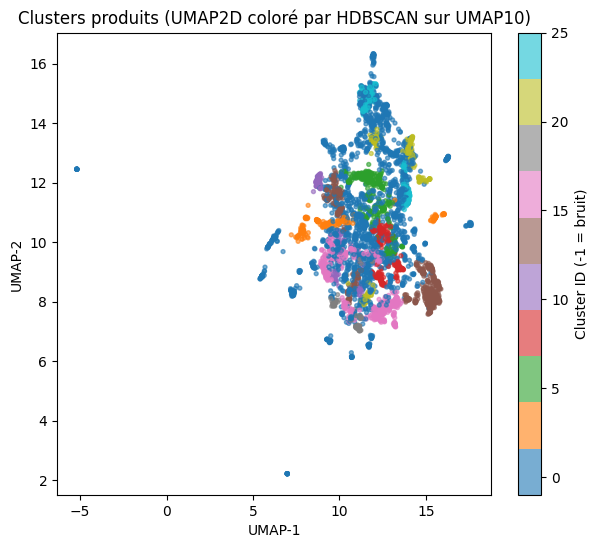

In [42]:

import types
import sklearn.utils.validation as skval
import umap.umap_ as umap

import hdbscan


# ========= 0. Préparation des features =========
X_full_df = pd.DataFrame(full_feature_scaled).astype(float).fillna(0.0)
X_full = X_full_df.values.astype(np.float32)

print("Shape X_full:", X_full.shape)
print("NaN ?", np.isnan(X_full).any())
print("Inf ?", np.isinf(X_full).any())


# ========= 1. Monkey patch check_array pour ignorer ensure_all_finite =========
_orig_check_array = skval.check_array  # on garde l'original

def check_array_patched(X, *args, **kwargs):
    # on enlève le paramètre problématique si présent
    if 'ensure_all_finite' in kwargs:
        kwargs = {k: v for k, v in kwargs.items() if k != 'ensure_all_finite'}
    return _orig_check_array(X, *args, **kwargs)

skval.check_array = check_array_patched  # PATCH ACTIVÉ


# ========= 2. UMAP (10 dimensions pour clustering) =========
umap_model_10 = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=10,
    metric='euclidean',
    random_state=42
)

X_umap10 = umap_model_10.fit_transform(X_full)
print("Shape après UMAP 10D:", X_umap10.shape)

# ========= 3. HDBSCAN sur l'espace UMAP10 =========
hdb_umap = hdbscan.HDBSCAN(
    min_cluster_size=50,
    min_samples=10,
    cluster_selection_method='leaf'
).fit(X_umap10)

labels_umap = hdb_umap.labels_
proba_umap  = hdb_umap.probabilities_

cluster_counts_umap = pd.Series(labels_umap).value_counts().sort_index()
print("\nClusters trouvés (y compris bruit = -1) :")
print(cluster_counts_umap)


# ========= 4. UMAP en 2D pour visualisation =========
umap_model_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)

X_umap2 = umap_model_2d.fit_transform(X_full)
print("Shape UMAP 2D:", X_umap2.shape)

plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_umap2[:,0],
    X_umap2[:,1],
    c=labels_umap,
    cmap='tab10',
    s=8,
    alpha=0.6
)
plt.title("Clusters produits (UMAP2D coloré par HDBSCAN sur UMAP10)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID (-1 = bruit)")
plt.show()


# ========= 5. On remet check_array proprement =========
skval.check_array = _orig_check_array


In [43]:
hdb_umap = hdbscan.HDBSCAN(
    min_cluster_size=50,          # taille minimale d'un vrai groupe produit
    min_samples=10,               # robustesse au bruit
    cluster_selection_method='leaf'  # plus granulaire
).fit(X_umap10)

labels_umap = hdb_umap.labels_               # cluster ID ou -1 pour bruit
proba_umap  = hdb_umap.probabilities_        # confiance du cluster pour chaque point

# Résumé
cluster_counts_umap = pd.Series(labels_umap).value_counts().sort_index()
print("Clusters trouvés (y compris bruit = -1) :")
print(cluster_counts_umap)


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Clusters trouvés (y compris bruit = -1) :
-1     1932
 0       68
 1       51
 2       61
 3       66
 4       96
 5      213
 6      134
 7       62
 8       77
 9       93
 10      53
 11      74
 12     136
 13     354
 14      55
 15     228
 16     109
 17     112
 18      57
 19      53
 20      79
 21      55
 22      78
 23      83
 24      78
 25      52
Name: count, dtype: int64


c:\Users\dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


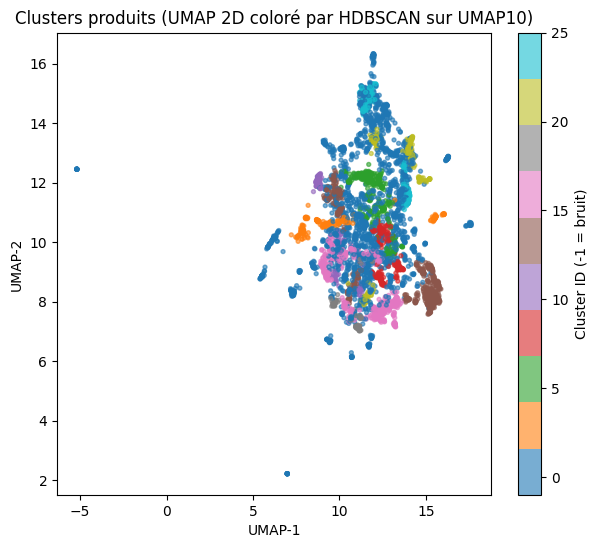

In [44]:
umap_model_2d = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric='euclidean',
    random_state=42
)
X_umap2 = umap_model_2d.fit_transform(full_feature_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(
    X_umap2[:,0],
    X_umap2[:,1],
    c=labels_umap,
    cmap='tab10',
    s=8,
    alpha=0.6
)
plt.title("Clusters produits (UMAP 2D coloré par HDBSCAN sur UMAP10)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster ID (-1 = bruit)")
plt.show()
